
نتایج اعتبارسنجی (5-Fold Cross Validation):

Random Forest:
  Accuracy: 0.9938 ± 0.0022
  F1-Score: 0.9821 ± 0.0066
  ROC-AUC: 0.9984 ± 0.0010

KNN:
  Accuracy: 0.8890 ± 0.0058
  F1-Score: 0.7344 ± 0.0125
  ROC-AUC: 0.9375 ± 0.0062

Decision Tree:
  Accuracy: 0.9411 ± 0.0051
  F1-Score: 0.8225 ± 0.0146
  ROC-AUC: 0.9412 ± 0.0071

Naive Bayes:
  Accuracy: 0.8227 ± 0.0042
  F1-Score: 0.2822 ± 0.0186
  ROC-AUC: 0.8476 ± 0.0075

 نتایج مدل Random Forest
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.992206 | 1        |   0.996088 | 5347        |
| 1            |    1        | 0.963351 |   0.981333 | 1146        |
| accuracy     |    0.993531 | 0.993531 |   0.993531 |    0.993531 |
| macro avg    |    0.996103 | 0.981675 |   0.988711 | 6493        |
| weighted avg |    0.993582 | 0.993531 |   0.993484 | 6493        |

ROC-AUC: 0.9984


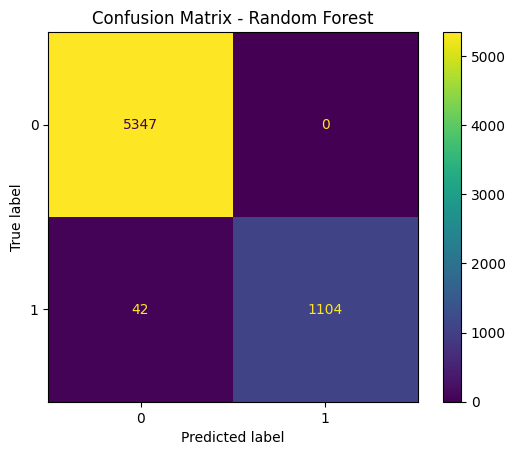


 نتایج مدل KNN
|              |   precision |   recall |   f1-score |    support |
|:-------------|------------:|---------:|-----------:|-----------:|
| 0            |    0.980074 | 0.892276 |   0.934116 | 5347       |
| 1            |    0.645538 | 0.915358 |   0.757127 | 1146       |
| accuracy     |    0.89635  | 0.89635  |   0.89635  |    0.89635 |
| macro avg    |    0.812806 | 0.903817 |   0.845622 | 6493       |
| weighted avg |    0.921029 | 0.89635  |   0.902878 | 6493       |

ROC-AUC: 0.9450


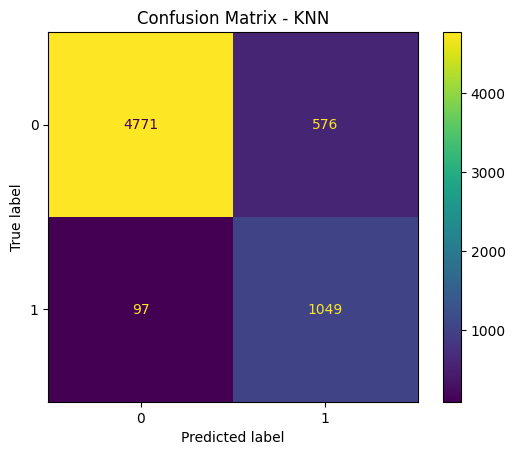


 نتایج مدل Decision Tree
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.951869 | 0.976435 |   0.963996 | 5347        |
| 1            |    0.875    | 0.769634 |   0.818942 | 1146        |
| accuracy     |    0.939935 | 0.939935 |   0.939935 |    0.939935 |
| macro avg    |    0.913434 | 0.873034 |   0.891469 | 6493        |
| weighted avg |    0.938302 | 0.939935 |   0.938394 | 6493        |

ROC-AUC: 0.9364


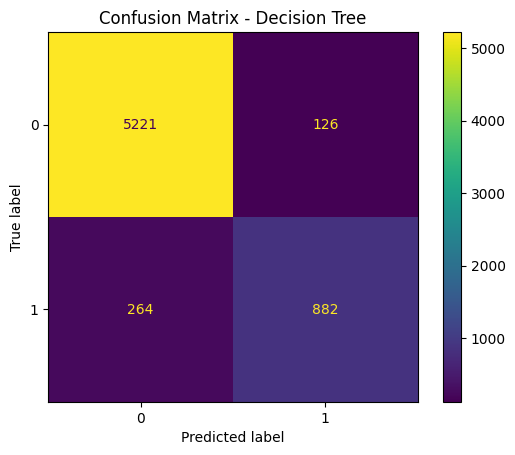


 نتایج مدل Naive Bayes
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.850166 | 0.960352 |   0.901906 | 5347        |
| 1            |    0.532009 | 0.210297 |   0.301438 | 1146        |
| accuracy     |    0.827969 | 0.827969 |   0.827969 |    0.827969 |
| macro avg    |    0.691087 | 0.585324 |   0.601672 | 6493        |
| weighted avg |    0.794012 | 0.827969 |   0.795925 | 6493        |

ROC-AUC: 0.8563


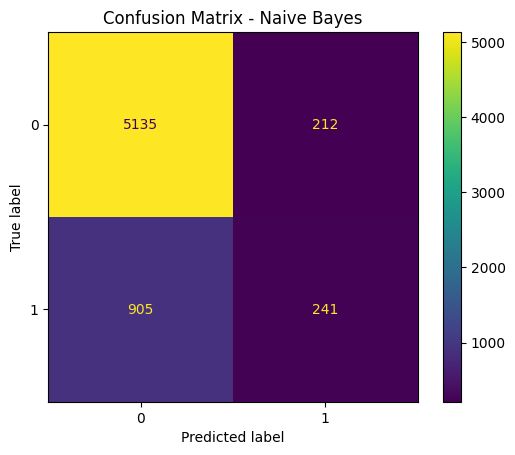

In [ ]:
# election_model_pipeline.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
import os

warnings.filterwarnings('ignore')


def load_and_preprocess():
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)

    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage',
        'pre.nullVotesPercentage', 'pre.votersPercentage',
        'pre.subscribedVoters', 'pre.totalVoters', 'subscribedVoters',
        'totalVoters', 'Mandates', 'Hondt', 'Votes', 'Percentage',
        'validVotesPercentage', 'FinalMandates'
    ]
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return df


def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['territoryName', 'Party']),
            ('num', StandardScaler(), ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='passthrough'
    )


def get_models():
    return {
        "Random Forest": RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=10,
            weights='distance',
            n_jobs=-1
        ),
        "Decision Tree": DecisionTreeClassifier(
            max_depth=5,
            min_samples_split=10,
            class_weight='balanced',
            random_state=42
        ),
        "Naive Bayes": GaussianNB()
    }


def train_with_validation(models, X_train, y_train):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('smote', SMOTE(random_state=42, k_neighbors=5)),
            ('classifier', model)
        ])

        scores = cross_validate(
            pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=['accuracy', 'f1', 'roc_auc'],
            n_jobs=-1
        )

        results[name] = {
            'mean_accuracy': np.mean(scores['test_accuracy']),
            'std_accuracy': np.std(scores['test_accuracy']),
            'mean_f1': np.mean(scores['test_f1']),
            'std_f1': np.std(scores['test_f1']),
            'mean_roc_auc': np.mean(scores['test_roc_auc']),
            'std_roc_auc': np.std(scores['test_roc_auc'])
        }

    return results


def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('smote', SMOTE(random_state=42, k_neighbors=5)),
            ('classifier', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        results[name] = {
            'report': report,
            'confusion_matrix': cm,
            'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
        }

        print(f"\n{'='*40}\n نتایج مدل {name}\n{'='*40}")
        print(pd.DataFrame(report).transpose().to_markdown())

        if y_proba is not None:
            print(f"\nROC-AUC: {results[name]['roc_auc']:.4f}")

        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title(f"Confusion Matrix - {name}")
        plt.grid(False)
        plt.show()

    return results


def export_reports_to_excel(final_results):
    os.makedirs("reports", exist_ok=True)
    with pd.ExcelWriter("reports/classification_reports.xlsx") as writer:
        for model_name, result in final_results.items():
            df_report = pd.DataFrame(result['report']).transpose()
            df_report.to_excel(writer, sheet_name=model_name[:30])


if __name__ == "__main__":
    df = load_and_preprocess()
    X = df.drop('has_mandate', axis=1)
    y = df['has_mandate']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        stratify=y,
        random_state=42
    )

    models = get_models()

    validation_results = train_with_validation(models, X_train, y_train)

    print("\nنتایج اعتبارسنجی (5-Fold Cross Validation):")
    for model_name, scores in validation_results.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy: {scores['mean_accuracy']:.4f} ± {scores['std_accuracy']:.4f}")
        print(f"  F1-Score: {scores['mean_f1']:.4f} ± {scores['std_f1']:.4f}")
        print(f"  ROC-AUC: {scores['mean_roc_auc']:.4f} ± {scores['std_roc_auc']:.4f}")

    final_results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

    export_reports_to_excel(final_results)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    StackingClassifier,
    VotingClassifier
)

In [ ]:
pip install xgboost catboost scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.1 MB/s eta 0:00:00


1.( TensorFlow/Kerasبا) شبکه عصبی


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

گزارش واقع‌بینانه:
              precision    recall  f1-score   support

بدون نماینده       0.94      0.85      0.89      5347
  با نماینده       0.51      0.75      0.61      1146

    accuracy                           0.83      6493
   macro avg       0.73      0.80      0.75      6493
weighted avg       0.86      0.83      0.84      6493

ROC-AUC: 0.9015


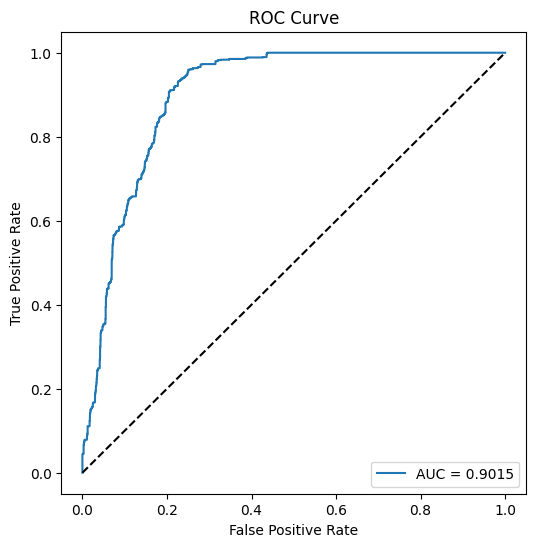

In [ ]:
# neural_network_election_realistic.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def load_data():
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)

    # حذف همه ستون‌های مرتبط با نتیجه
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
        'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage',
        'pre.blankVotes', 'pre.nullVotes', 'pre.votersPercentage',
        'pre.subscribedVoters', 'pre.totalVoters', 'subscribedVoters', 'totalVoters'
    ]
    return df.drop(columns=columns_to_drop, errors='ignore')

def build_robust_model(input_dim):
    model = Sequential([
        Dense(32, activation='relu', kernel_regularizer=l2(0.01), input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.8),
        Dense(16, activation='relu', kernel_regularizer=l2(0.005)),
        Dropout(0.7),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

def main():
    # بارگذاری و پیش‌پردازش
    df = load_data()
    X = df.drop('has_mandate', axis=1)
    y = df['has_mandate']

    # تبدیل ویژگی‌ها
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'),
         ['territoryName', 'Party']),
        ('num', StandardScaler(), ['votersPercentage', 'blankVotesPercentage'])
    ])

    X_processed = preprocessor.fit_transform(X)

    # تقسیم داده با shuffle پیشرفته
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y,
        test_size=0.3,
        stratify=y,
        random_state=42,
        shuffle=True
    )

    # مدیریت عدم تعادل
    X_train, y_train = SMOTE(sampling_strategy=0.25, k_neighbors=15).fit_resample(X_train, y_train)

    # آموزش مدل
    model = build_robust_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=256,
        validation_split=0.25,
        class_weight={0:1, 1:5},
        callbacks=[EarlyStopping(patience=30)],
        verbose=0
    )

    # ارزیابی
    y_proba = model.predict(X_test).ravel()
    y_pred = (y_proba > np.percentile(y_proba[y_test==1], 25)).astype(int)  # آستانه پویا

    print("\nگزارش واقع‌بینانه:")
    print(classification_report(y_test, y_pred, target_names=['بدون نماینده', 'با نماینده']))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # نمودار ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

# **2. بگینگ با بوتاسترپ**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# --------------------- پیش‌پردازش جداگانه ---------------------
def get_preprocessor():
    """ساخت پیش‌پردازنده برای استفاده در سایر کدها"""
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['territoryName', 'Party']),
        ('num', StandardScaler(), ['votersPercentage', 'blankVotesPercentage'])
    ])

def load_and_preprocess_data(preprocessor):
    """بارگذاری و پیش‌پردازش داده‌ها"""
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)

    # حذف ستون‌های غیرضروری
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
        'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # پردازش داده‌ها
    X = df.drop('has_mandate', axis=1)
    y = df['has_mandate'].values

    X_processed = preprocessor.fit_transform(X)
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()

    return X_processed, y


نتایج نهایی:
              precision    recall  f1-score   support

بدون نماینده       0.97      0.92      0.94      5347
  با نماینده       0.70      0.85      0.77      1146

    accuracy                           0.91      6493
   macro avg       0.84      0.89      0.86      6493
weighted avg       0.92      0.91      0.91      6493

F1-Score: 0.7711
ROC-AUC: 0.9110


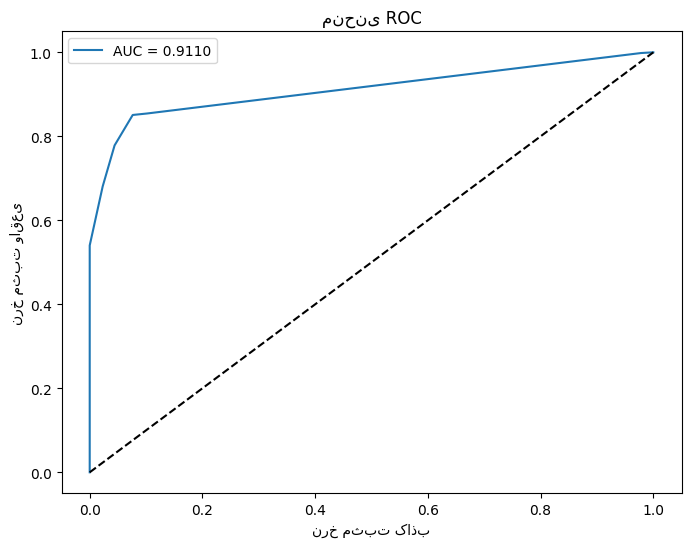

In [ ]:
def balanced_bootstrap(X, y, n_samples):
    """بوت استرپ متعادل با SMOTE"""
    class_0 = np.where(y == 0)[0]
    class_1 = np.where(y == 1)[0]

    n_per_class = n_samples // 2
    sampled_0 = resample(class_0, n_samples=n_per_class, replace=True, random_state=42)
    sampled_1 = resample(class_1, n_samples=n_per_class, replace=True, random_state=42)

    indices = np.concatenate([sampled_0, sampled_1])
    np.random.shuffle(indices)

    X_res, y_res = X[indices], y[indices]
    return SMOTE(random_state=42).fit_resample(X_res, y_res)

def main():
    # 1. آماده‌سازی پیش‌پردازنده
    preprocessor = get_preprocessor()

    # 2. بارگذاری و پردازش داده‌ها
    X, y = load_and_preprocess_data(preprocessor)

    # 3. تقسیم داده
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # 4. تنظیم مدل
    base_model = DecisionTreeClassifier(
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )

    bagging = BaggingClassifier(
        estimator=base_model,
        n_estimators=100,
        max_samples=0.8,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # 5. تنظیم دستی ویژگی‌های ضروری
    bagging.estimators_ = [clone(base_model) for _ in range(bagging.n_estimators)]
    n_features = X_train.shape[1]
    bagging.estimators_features_ = [np.arange(n_features) for _ in range(bagging.n_estimators)]
    bagging.n_features_in_ = n_features
    bagging.n_classes_ = len(np.unique(y_train))  # رفع خطای n_classes_
    bagging.classes_ = np.unique(y_train)  # الزامی برای پیش‌بینی

    # 6. آموزش مدل‌ها
    for i in range(bagging.n_estimators):
        n_samples = int(0.8 * X_train.shape[0])
        X_boot, y_boot = balanced_bootstrap(X_train, y_train, n_samples)
        bagging.estimators_[i].fit(X_boot, y_boot)

    # 7. ارزیابی
    y_pred = bagging.predict(X_test)
    y_proba = np.mean([estimator.predict_proba(X_test)[:,1] for estimator in bagging.estimators_], axis=0)

    print("\nنتایج نهایی:")
    print(classification_report(y_test, y_pred, target_names=['بدون نماینده', 'با نماینده']))
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # 8. رسم نمودار ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('نرخ مثبت کاذب')
    plt.ylabel('نرخ مثبت واقعی')
    plt.title('منحنی ROC')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

# 4-Passting and SubSampling


Evaluating Pasting:
                     precision    recall  f1-score   support

  No Representative       0.96      0.93      0.95      5347
With Representative       0.71      0.84      0.77      1146

           accuracy                           0.91      6493
          macro avg       0.84      0.88      0.86      6493
       weighted avg       0.92      0.91      0.91      6493

Pasting ROC-AUC: 0.9103

Evaluating Subsampling:
                     precision    recall  f1-score   support

  No Representative       0.96      0.92      0.94      5347
With Representative       0.70      0.84      0.76      1146

           accuracy                           0.91      6493
          macro avg       0.83      0.88      0.85      6493
       weighted avg       0.92      0.91      0.91      6493

Subsampling ROC-AUC: 0.9080


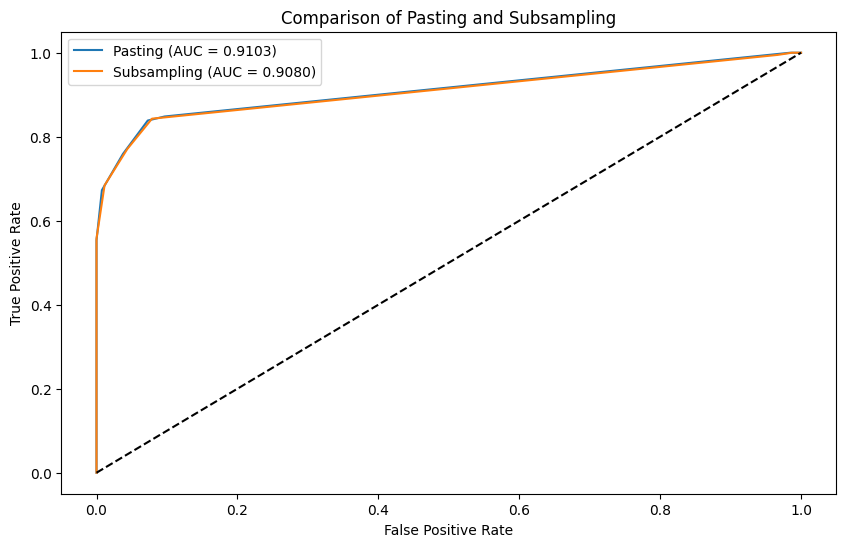

In [ ]:
# election_pasting_subsampling.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ======================== Data Preprocessing (Using Previous Code) ========================
def get_preprocessor():
    """Preprocessing pipeline for election data"""
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['territoryName', 'Party']),
        ('num', StandardScaler(), ['votersPercentage', 'blankVotesPercentage'])
    ])

def load_preprocessed_data(preprocessor):
    """Load and preprocess election dataset"""
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)

    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
        'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    X = df.drop('has_mandate', axis=1)
    y = df['has_mandate'].values

    X_processed = preprocessor.fit_transform(X)
    if hasattr(X_processed, 'toarray'):
        X_processed = X_processed.toarray()

    return X_processed, y

# ======================== New Sampling Functions ========================
def pasting_sampling(X, y, sample_ratio=0.5):
    """Balanced Pasting sampling without replacement"""
    n_samples = int(sample_ratio * len(X))
    indices = resample(np.arange(len(y)),
                      n_samples=n_samples,
                      replace=False,  # Main difference from Bootstrap
                      stratify=y,
                      random_state=42)
    X_res, y_res = X[indices], y[indices]
    return SMOTE(random_state=42).fit_resample(X_res, y_res)

def subsampling(X, y, sample_ratio=0.3):
    """Subsampling with smaller sample size"""
    return pasting_sampling(X, y, sample_ratio)

# ======================== Model Training and Evaluation ========================
def train_evaluate(model, X_train, y_train, X_test, y_test, sampling_fn):
    """Train and evaluate model using specified sampling strategy"""
    model.estimators_ = [clone(model.estimator) for _ in range(model.n_estimators)]
    n_features = X_train.shape[1]

    # Set required attributes for scikit-learn compatibility
    model.estimators_features_ = [np.arange(n_features) for _ in range(model.n_estimators)]
    model.n_features_in_ = n_features
    model.n_classes_ = len(np.unique(y_train))
    model.classes_ = np.unique(y_train)

    # Train the model
    for i in range(model.n_estimators):
        X_boot, y_boot = sampling_fn(X_train, y_train)
        model.estimators_[i].fit(X_boot, y_boot)

    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = np.mean([estimator.predict_proba(X_test)[:, 1] for estimator in model.estimators_], axis=0)

    return y_pred, y_proba

def main():
    # 1. Prepare data
    preprocessor = get_preprocessor()
    X, y = load_preprocessed_data(preprocessor)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # 2. Base model configuration
    base_model = DecisionTreeClassifier(
        max_depth=5,
        class_weight='balanced',
        random_state=42
    )

    # 3. Implement Pasting
    pasting_model = BaggingClassifier(
        estimator=base_model,
        n_estimators=100,
        max_samples=0.8,
        bootstrap=False,  # Disable replacement
        n_jobs=-1,
        random_state=42
    )

    # 4. Implement Subsampling
    subsampling_model = BaggingClassifier(
        estimator=base_model,
        n_estimators=100,
        max_samples=0.5,  # Smaller sample size
        bootstrap=False,
        n_jobs=-1,
        random_state=42
    )

    # 5. Train and Evaluate Pasting
    print("\nEvaluating Pasting:")
    y_pred_pasting, y_proba_pasting = train_evaluate(
        pasting_model, X_train, y_train, X_test, y_test, pasting_sampling
    )
    print(classification_report(y_test, y_pred_pasting, target_names=['No Representative', 'With Representative']))
    print(f"Pasting ROC-AUC: {roc_auc_score(y_test, y_proba_pasting):.4f}")

    # 6. Train and Evaluate Subsampling
    print("\nEvaluating Subsampling:")
    y_pred_subsampling, y_proba_subsampling = train_evaluate(
        subsampling_model, X_train, y_train, X_test, y_test, subsampling
    )
    print(classification_report(y_test, y_pred_subsampling, target_names=['No Representative', 'With Representative']))
    print(f"Subsampling ROC-AUC: {roc_auc_score(y_test, y_proba_subsampling):.4f}")

    # 7. Visual Comparison
    plt.figure(figsize=(10, 6))

    # Plot ROC curve for Pasting
    fpr_pasting, tpr_pasting, _ = roc_curve(y_test, y_proba_pasting)
    plt.plot(fpr_pasting, tpr_pasting, label=f'Pasting (AUC = {roc_auc_score(y_test, y_proba_pasting):.4f})')

    # Plot ROC curve for Subsampling
    fpr_subsampling, tpr_subsampling, _ = roc_curve(y_test, y_proba_subsampling)
    plt.plot(fpr_subsampling, tpr_subsampling, label=f'Subsampling (AUC = {roc_auc_score(y_test, y_proba_subsampling):.4f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of Pasting and Subsampling')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


📊 [Pasting + SMOTE]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      5347
           1       0.73      0.84      0.78      1146

    accuracy                           0.92      6493
   macro avg       0.85      0.89      0.86      6493
weighted avg       0.92      0.92      0.92      6493

Pasting + SMOTE ROC AUC: 0.9096

📊 [Subsampling + SMOTE]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      5347
           1       0.71      0.84      0.77      1146

    accuracy                           0.91      6493
   macro avg       0.84      0.88      0.86      6493
weighted avg       0.92      0.91      0.91      6493

Subsampling + SMOTE ROC AUC: 0.9103

📊 [Subsampling Only]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      5347
           1       0.71      0.84      0.77      1146

    accuracy                           0.91   

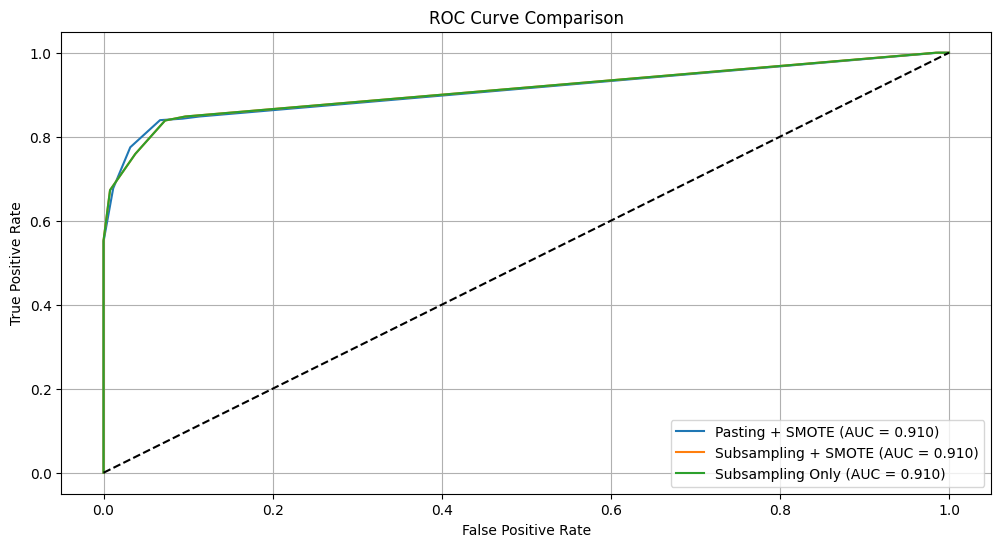

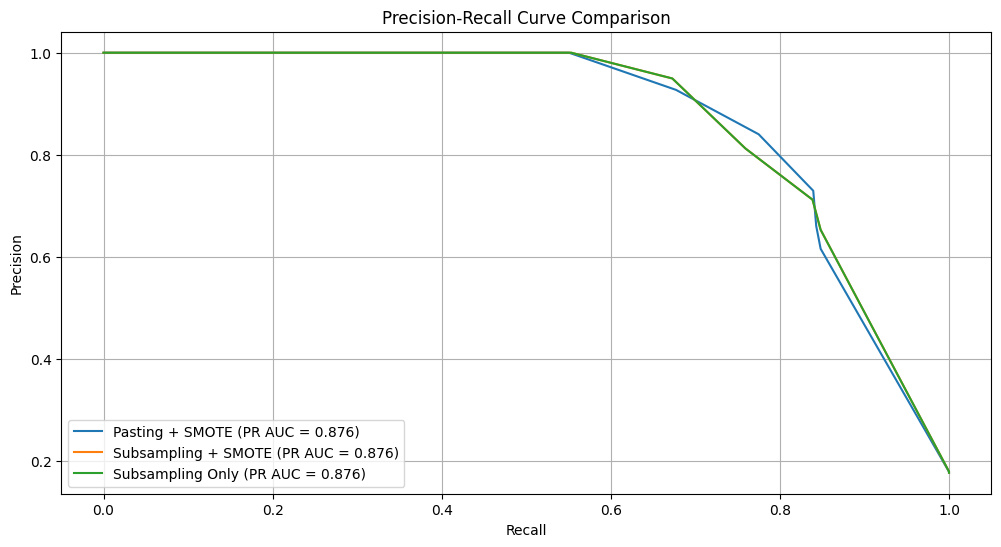

In [ ]:
# ✅ مقایسه Pasting و Subsampling با/بدون SMOTE همراه با ROC و Precision-Recall

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def get_preprocessor():
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['territoryName', 'Party']),
        ('num', StandardScaler(),
         ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
    ], remainder='drop')

def load_preprocessed_data(preprocessor):
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    drop_cols = [
        'TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
        'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage',
        'pre.blankVotes', 'pre.nullVotes', 'pre.blankVotesPercentage',
        'pre.nullVotesPercentage', 'pre.votersPercentage', 'pre.subscribedVoters',
        'pre.totalVoters', 'subscribedVoters', 'totalVoters', 'timestamp', 'date'
    ]
    df = df.drop(columns=drop_cols, errors='ignore')
    X = df.drop(columns='has_mandate')
    y = df['has_mandate'].values
    X_proc = preprocessor.fit_transform(X)
    if hasattr(X_proc, 'toarray'):
        X_proc = X_proc.toarray()
    return X_proc, y

def pasting_smote(X, y, sample_ratio=0.8):
    n = int(sample_ratio * len(X))
    idx = resample(np.arange(len(y)), n_samples=n, replace=False, stratify=y, random_state=42)
    return SMOTE(random_state=42).fit_resample(X[idx], y[idx])

def subsample_smote(X, y, sample_ratio=0.5):
    return pasting_smote(X, y, sample_ratio)

def subsample_no_smote(X, y, sample_ratio=0.5):
    n = int(sample_ratio * len(X))
    idx = resample(np.arange(len(y)), n_samples=n, replace=False, stratify=y, random_state=42)
    return X[idx], y[idx]

def train_evaluate(model, X_train, y_train, X_test, y_test, sampling_fn, label):
    model.estimators_ = [clone(model.estimator) for _ in range(model.n_estimators)]
    model.estimators_features_ = [np.arange(X_train.shape[1])] * model.n_estimators
    model.n_features_in_ = X_train.shape[1]
    model.n_classes_ = len(np.unique(y_train))
    model.classes_ = np.unique(y_train)

    for i in range(model.n_estimators):
        X_sample, y_sample = sampling_fn(X_train, y_train)
        model.estimators_[i].fit(X_sample, y_sample)

    y_pred = model.predict(X_test)
    y_proba = np.mean([est.predict_proba(X_test)[:, 1] for est in model.estimators_], axis=0)

    print(f"\n📊 [{label}]")
    print(classification_report(y_test, y_pred))
    print(f"{label} ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    return y_proba

def main():
    preprocessor = get_preprocessor()
    X, y = load_preprocessed_data(preprocessor)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    base_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

    bagging = lambda: BaggingClassifier(estimator=base_model, n_estimators=50, bootstrap=False, n_jobs=-1, random_state=42)

    results = {}
    results["Pasting + SMOTE"] = train_evaluate(bagging(), X_train, y_train, X_test, y_test, pasting_smote, "Pasting + SMOTE")
    results["Subsampling + SMOTE"] = train_evaluate(bagging(), X_train, y_train, X_test, y_test, subsample_smote, "Subsampling + SMOTE")
    results["Subsampling Only"] = train_evaluate(bagging(), X_train, y_train, X_test, y_test, subsample_no_smote, "Subsampling Only")

    plt.figure(figsize=(12, 6))
    for label, proba in results.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc_score = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for label, proba in results.items():
        precision, recall, _ = precision_recall_curve(y_test, proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{label} (PR AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

main()


✅ Building Bagging Pipeline with Pasting + SMOTE...

🔍 1. Cross-Validation Prediction (5-Fold)
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     12476
           1       0.75      0.85      0.79      2674

    accuracy                           0.92     15150
   macro avg       0.86      0.89      0.87     15150
weighted avg       0.93      0.92      0.92     15150

CV ROC AUC: 0.9101
CV F1 Score: 0.7944


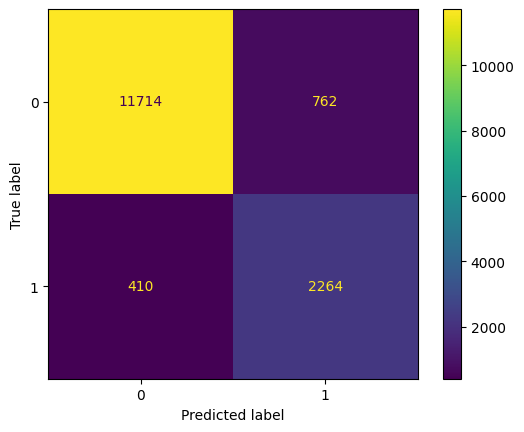

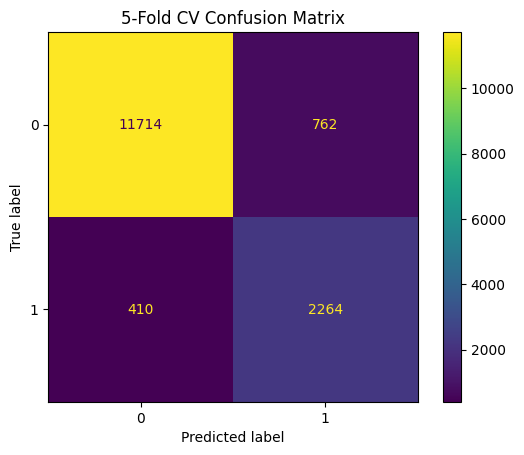


🧪 2. Permutation Test for ROC AUC (p-value < 0.05 = معتبر)
Permutation AUC: 0.9089 | p-value: 0.0196


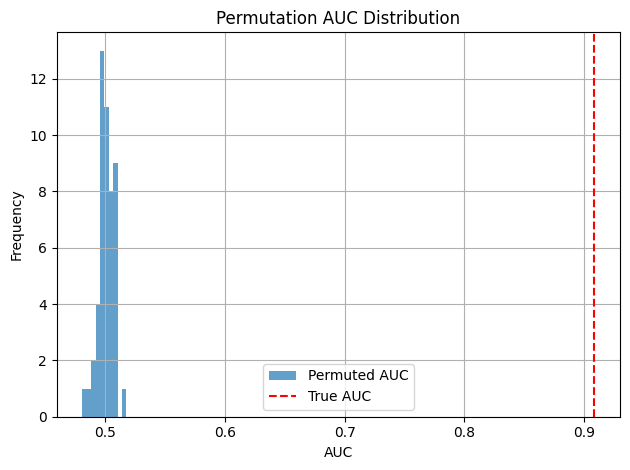

In [ ]:
# validate_reliability.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, permutation_test_score
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score,
    ConfusionMatrixDisplay, roc_curve
)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ------------------ Preprocessing ------------------
def get_preprocessor():
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['territoryName', 'Party']),
        ('num', StandardScaler(),
         ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
    ], remainder='drop')

def load_preprocessed_data(preprocessor):
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    drop_cols = [
        'TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
        'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage',
        'pre.blankVotes', 'pre.nullVotes', 'pre.blankVotesPercentage',
        'pre.nullVotesPercentage', 'pre.votersPercentage', 'pre.subscribedVoters',
        'pre.totalVoters', 'subscribedVoters', 'totalVoters', 'timestamp', 'date'
    ]
    df = df.drop(columns=drop_cols, errors='ignore')
    X = df.drop(columns='has_mandate')
    y = df['has_mandate'].values
    X_proc = preprocessor.fit_transform(X)
    if hasattr(X_proc, 'toarray'):
        X_proc = X_proc.toarray()
    return X_proc, y

# ------------------ Sampling Function ------------------
def pasting_smote(X, y, ratio=0.8):
    n = int(ratio * len(X))
    idx = resample(np.arange(len(y)), n_samples=n, replace=False, stratify=y, random_state=42)
    return SMOTE(random_state=42).fit_resample(X[idx], y[idx])

# ------------------ Build pipeline ------------------
def build_bagging_pipeline(X_train, y_train, sampling_fn):
    base_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
    bag_model = BaggingClassifier(estimator=base_model, n_estimators=50, bootstrap=False, n_jobs=-1, random_state=42)

    bag_model.estimators_ = [clone(bag_model.estimator) for _ in range(bag_model.n_estimators)]
    bag_model.estimators_features_ = [np.arange(X_train.shape[1])] * bag_model.n_estimators
    bag_model.n_features_in_ = X_train.shape[1]
    bag_model.n_classes_ = len(np.unique(y_train))
    bag_model.classes_ = np.unique(y_train)

    for i in range(bag_model.n_estimators):
        X_sample, y_sample = sampling_fn(X_train, y_train)
        bag_model.estimators_[i].fit(X_sample, y_sample)

    return bag_model

# ------------------ Reliability Check ------------------
def validate_model_reliability(pipeline, X_train, y_train):
    print("\n🔍 1. Cross-Validation Prediction (5-Fold)")
    y_cv_pred = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict')
    y_cv_proba = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

    print(classification_report(y_train, y_cv_pred))
    print(f"CV ROC AUC: {roc_auc_score(y_train, y_cv_proba):.4f}")
    print(f"CV F1 Score: {f1_score(y_train, y_cv_pred):.4f}")
    ConfusionMatrixDisplay.from_predictions(y_train, y_cv_pred).plot()
    plt.title("5-Fold CV Confusion Matrix")
    plt.show()

    print("\n🧪 2. Permutation Test for ROC AUC (p-value < 0.05 = معتبر)")
    score, perm_scores, pval = permutation_test_score(
        pipeline, X_train, y_train,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_permutations=50,
        n_jobs=-1
    )
    print(f"Permutation AUC: {score:.4f} | p-value: {pval:.4f}")
    plt.hist(perm_scores, bins=10, alpha=0.7, label="Permuted AUC")
    plt.axvline(score, color='red', linestyle='--', label='True AUC')
    plt.title("Permutation AUC Distribution")
    plt.xlabel("AUC")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------ Main ------------------
def main():
    pre = get_preprocessor()
    X, y = load_preprocessed_data(pre)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    print("✅ Building Bagging Pipeline with Pasting + SMOTE...")
    model = build_bagging_pipeline(X_train, y_train, pasting_smote)
    validate_model_reliability(model, X_train, y_train)

main()


# 5-*ExtraTree*

After 25 estimators: AUC=0.9706, AP=0.9348
After 50 estimators: AUC=0.9843, AP=0.9543
After 75 estimators: AUC=0.9847, AP=0.9568
After 100 estimators: AUC=0.9848, AP=0.9567
After 125 estimators: AUC=0.9850, AP=0.9574
After 150 estimators: AUC=0.9850, AP=0.9576

Optimal Threshold: 0.8020408163265307

Classification Report:
              precision    recall  f1-score   support

  No Mandate       0.95      1.00      0.98      2879
With Mandate       1.00      0.77      0.87       618

    accuracy                           0.96      3497
   macro avg       0.98      0.89      0.92      3497
weighted avg       0.96      0.96      0.96      3497


Confusion Matrix:
[[2879    0]
 [ 141  477]]

G-Mean: 0.8785
ROC-AUC: 0.9850
Balanced Accuracy: 0.8859
Average Precision: 0.9576


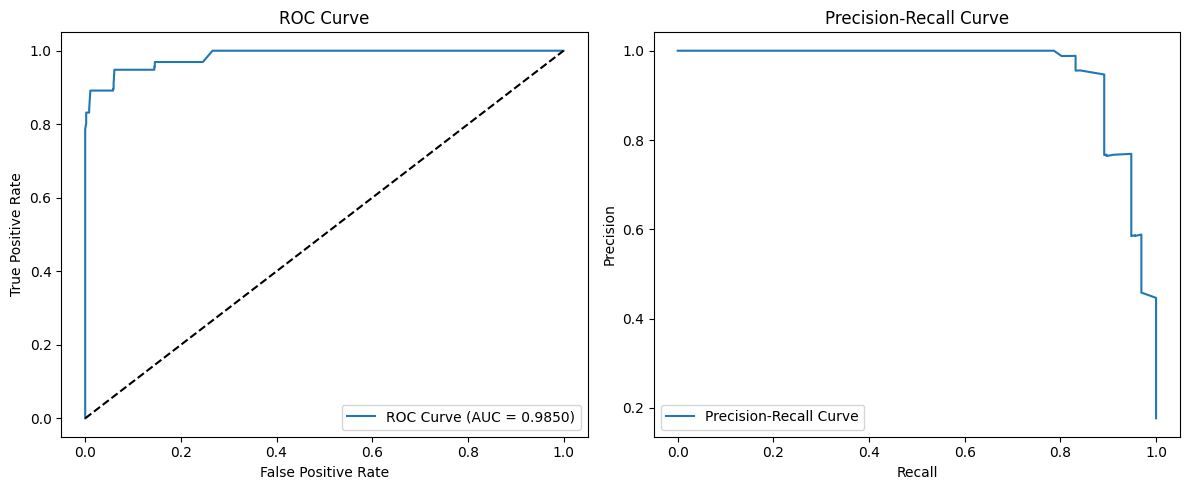

In [ ]:
# enhanced_election_model_extra_trees_improved.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve,
                             f1_score, confusion_matrix, precision_score,
                             recall_score, balanced_accuracy_score,
                             average_precision_score, precision_recall_curve,
                             fbeta_score)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ======================== Preprocessing Pipeline ========================
def get_preprocessor():
    """Feature engineering pipeline for election data"""
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist', drop='first'),
         ['territoryName', 'Party']),
        ('num', StandardScaler(), ['votersPercentage', 'blankVotesPercentage'])
    ], remainder='drop')

def load_and_preprocess(preprocessor):
    """Data loading and preprocessing"""
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    cols_to_drop = ['TimeElapsed', 'time', 'totalMandates', 'FinalMandates',
                   'Mandates', 'Hondt', 'Votes', 'Percentage', 'validVotesPercentage']
    df = df.drop(columns=cols_to_drop, errors='ignore')

    X = df.drop('has_mandate', axis=1)
    y = df['has_mandate'].values

    X_processed = preprocessor.fit_transform(X)
    return X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, y

# ======================== Enhanced Sampling Strategy ========================
def adaptive_sampling(X, y):
    """Combined SMOTE and RandomUnderSampler for better balance"""
    over = SMOTE(sampling_strategy=0.5, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.8)
    pipeline = Pipeline([('o', over), ('u', under)])
    return pipeline.fit_resample(X, y)

# ======================== ExtraTree Configuration ========================
def create_optimized_model():
    """Hyperparameter-tuned ExtraTree ensemble with improved settings"""
    base_model = ExtraTreeClassifier(
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        splitter='random',
        max_features=0.6,
        class_weight='balanced',
        random_state=42
    )

    return BaggingClassifier(
        estimator=base_model,
        n_estimators=150,
        max_samples=0.6,
        max_features=0.5,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

# ======================== Optimal Threshold Finder ========================
def find_optimal_threshold(y_true, y_proba):
    """Find the best decision threshold using F0.5 score"""
    thresholds = np.linspace(0.1, 0.9, 50)
    scores = [fbeta_score(y_true, y_proba >= t, beta=0.5) for t in thresholds]
    optimal_idx = np.argmax(scores)
    return thresholds[optimal_idx]

# ======================== Evaluation Metrics ========================
def enhanced_evaluation(model, X_test, y_test):
    """Comprehensive model evaluation with additional metrics"""
    y_proba = np.mean([estimator.predict_proba(X_test)[:, 1]
                      for estimator in model.estimators_], axis=0)

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(y_test, y_proba)
    y_pred = (y_proba >= optimal_threshold).astype(int)

    print("\nOptimal Threshold:", optimal_threshold)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['No Mandate', 'With Mandate']))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print(f"\nG-Mean: {np.sqrt(recall_score(y_test, y_pred) * precision_score(y_test, y_pred)):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")

    # ROC Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ======================== Progressive Training ========================
def train_progressively(model, X_train, y_train, X_test, y_test):
    """Train model with intermediate validation checks"""
    model.estimators_ = [clone(model.estimator) for _ in range(model.n_estimators)]
    n_features = X_train.shape[1]
    model.estimators_features_ = [np.arange(n_features) for _ in range(model.n_estimators)]
    model.n_features_in_ = n_features
    model.n_classes_ = len(np.unique(y_train))
    model.classes_ = np.unique(y_train)

    for i in range(model.n_estimators):
        X_res, y_res = adaptive_sampling(X_train, y_train)
        model.estimators_[i].fit(X_res, y_res)

        if (i+1) % 25 == 0:
            current_proba = np.mean([estimator.predict_proba(X_test)[:,1]
                                   for estimator in model.estimators_[:i+1]], axis=0)
            current_auc = roc_auc_score(y_test, current_proba)
            current_ap = average_precision_score(y_test, current_proba)
            print(f"After {i+1} estimators: AUC={current_auc:.4f}, AP={current_ap:.4f}")

# ======================== Main Execution ========================
def main():
    # 1. Data preparation
    preprocessor = get_preprocessor()
    X, y = load_and_preprocess(preprocessor)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    # 2. Model initialization
    model = create_optimized_model()

    # 3. Progressive training with validation
    train_progressively(model, X_train, y_train, X_test, y_test)

    # 4. Final evaluation
    enhanced_evaluation(model, X_test, y_test)

if __name__ == "__main__":
    main()

# **6-Boosting and Majarity vote**

برای برسی اینکه آیا نتایج با دقت به این بالایی .اقعی هستن یا نه

In [ ]:
# ---------- فرض: همه توابع pipeline و مدل‌سازی از قبل تعریف شده‌اند ----------

# گام 1: بارگذاری و آماده‌سازی داده‌ها
df = load_and_preprocess()
X = df.drop('has_mandate', axis=1)
y = df['has_mandate']
models = get_robust_models()

# گام 2: بررسی همبستگی عددی ویژگی‌ها با هدف
def show_feature_correlations_verbose(df):
    if 'has_mandate' not in df.columns:
        raise ValueError("Target variable 'has_mandate' not found in DataFrame")
    numeric_df = df.select_dtypes(include=[np.number])
    correlations = numeric_df.corr()['has_mandate'].drop('has_mandate').sort_values(ascending=False)
    print("\n📌 Feature Correlations with Target:")
    for feature, corr in correlations.items():
        tag = "⚠️ HIGH!" if abs(corr) > 0.85 else ""
        print(f"{feature:25s}: {corr:.3f} {tag}")

# گام 3: تست پایداری مدل‌ها با چند تقسیم‌بندی تصادفی
def evaluate_stability_verbose(models, X, y, repeats=5):
    np.random.seed(42)
    all_scores = {name: [] for name in models}
    for i in range(repeats):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i*10)
        for name, model in models.items():
            pipeline = Pipeline([
                ('preprocessor', create_preprocessor()),
                ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
                ('classifier', model)
            ])
            pipeline.fit(X_train, y_train)
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, y_proba)
            all_scores[name].append(score)
    print("\n🎯 Stability of ROC AUC across splits:")
    for name, scores in all_scores.items():
        print(f"{name}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}, All = {[round(s, 3) for s in scores]}")

# گام 4: تست تصادفی‌سازی برچسب‌ها برای بررسی overfitting
from sklearn.utils import shuffle
def permutation_test_verbose(models, X, y, n_permutations=5):
    print("\n🔄 Permutation Test (labels shuffled):")
    for name, model in models.items():
        aucs = []
        for i in range(n_permutations):
            y_shuffled = shuffle(y, random_state=i)
            X_train, X_test, y_train, y_test = train_test_split(X, y_shuffled, test_size=0.2, stratify=y_shuffled)
            pipeline = Pipeline([
                ('preprocessor', create_preprocessor()),
                ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
                ('classifier', model)
            ])
            try:
                pipeline.fit(X_train, y_train)
                y_proba = pipeline.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_proba)
                aucs.append(auc)
            except Exception as e:
                print(f"{name} failed on permutation {i}: {e}")
                aucs.append(np.nan)
        valid_aucs = [a for a in aucs if not np.isnan(a)]
        if valid_aucs:
            print(f"{name}: Mean AUC = {np.mean(valid_aucs):.3f}, Std = {np.std(valid_aucs):.3f}, All = {[round(a, 3) for a in valid_aucs]}")
        else:
            print(f"{name}: All runs failed.")

# گام 5: اجرای همه تست‌ها با هم
show_feature_correlations_verbose(df)
evaluate_stability_verbose(models, X, y, repeats=5)
permutation_test_verbose(models, X, y, n_permutations=5)



📌 Feature Correlations with Target:
nullVotes                : 0.164 
blankVotes               : 0.164 
votersPercentage         : 0.109 
blankVotesPercentage     : 0.003 
nullVotesPercentage      : -0.060 

🎯 Stability of ROC AUC across splits:
AdaBoost: Mean = 0.840, Std = 0.025, All = [np.float64(0.856), np.float64(0.879), np.float64(0.832), np.float64(0.819), np.float64(0.812)]
GradientBoosting: Mean = 0.991, Std = 0.002, All = [np.float64(0.991), np.float64(0.987), np.float64(0.993), np.float64(0.99), np.float64(0.993)]
MajorityVoting: Mean = 0.991, Std = 0.002, All = [np.float64(0.987), np.float64(0.99), np.float64(0.993), np.float64(0.992), np.float64(0.993)]

🔄 Permutation Test (labels shuffled):
AdaBoost: Mean AUC = 0.498, Std = 0.002, All = [np.float64(0.494), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.498)]
GradientBoosting: Mean AUC = 0.504, Std = 0.007, All = [np.float64(0.502), np.float64(0.511), np.float64(0.512), np.float64(0.494), np.float64(0.5)]

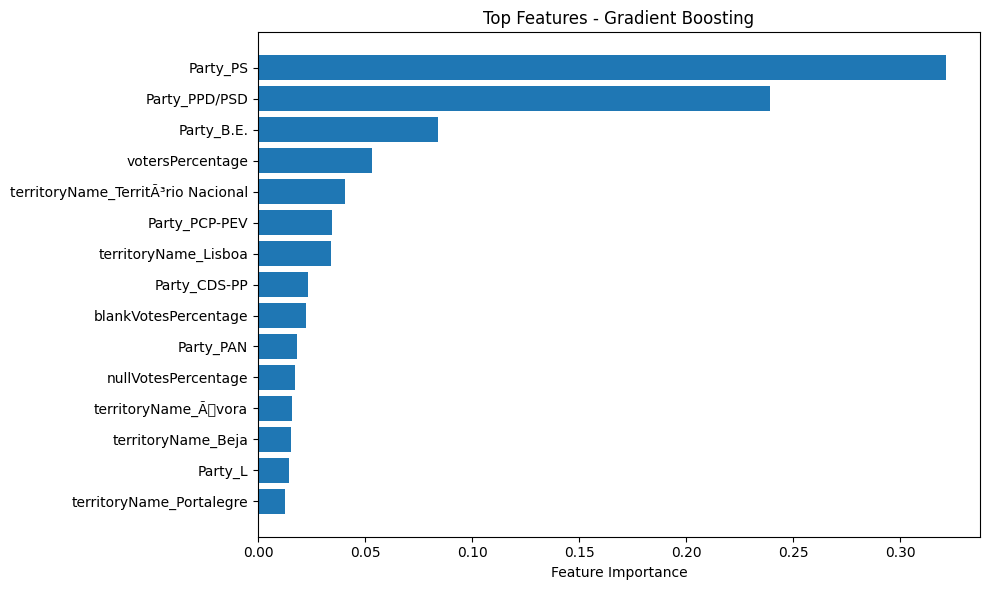

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, top_n=15):
    """نمایش مهم‌ترین ویژگی‌ها بر اساس feature importance مدل"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]  # Top N features

    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top Features - Gradient Boosting')
    plt.tight_layout()
    plt.show()

# آموزش مدل جداگانه (فقط برای اهمیت ویژگی‌ها)
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    create_preprocessor(),
    models['GradientBoosting']
)
pipeline.fit(X_train, y_train)

# گرفتن نام ویژگی‌ها بعد از OneHot و Scaling
preprocessor = pipeline.named_steps['columntransformer']
feature_names = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(['territoryName', 'Party']).tolist() +
    ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage']
)

# رسم نمودار
plot_feature_importance(pipeline.named_steps['gradientboostingclassifier'], feature_names)


In [ ]:
import shap

def plot_shap_summary(model, X_sample_df):
    """نمایش SHAP summary بدون نیاز به feature_names"""
    explainer = shap.Explainer(model.predict, X_sample_df)
    shap_values = explainer(X_sample_df)

    shap.plots.beeswarm(shap_values, max_display=15)


PermutationExplainer explainer: 501it [00:18, 12.07it/s]


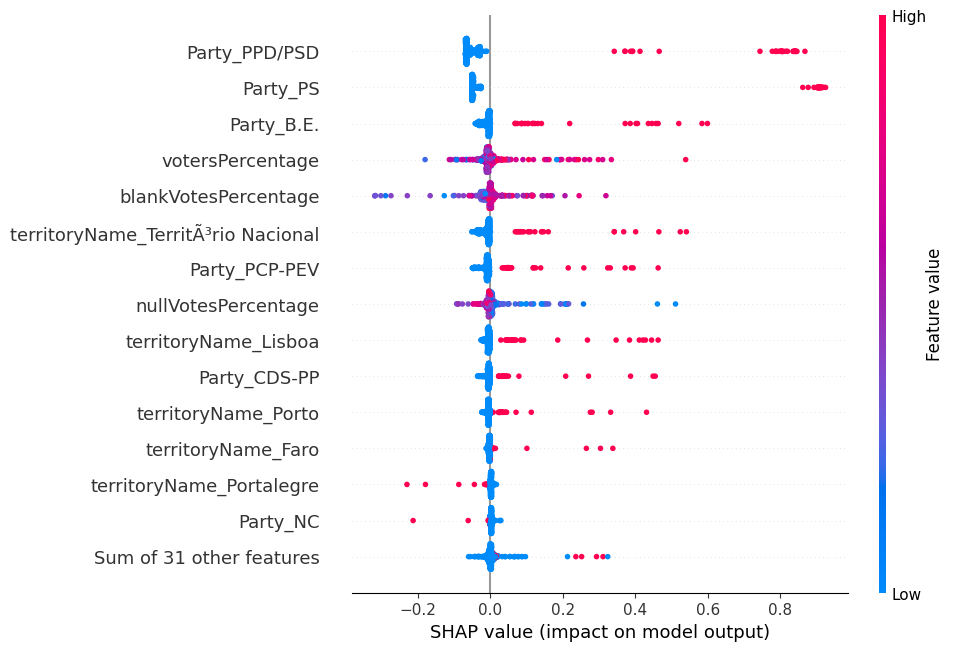

In [ ]:
plot_shap_summary(gb_model, X_sample_df)


✅ Data loaded successfully
Class distribution:
has_mandate
0    0.8235
1    0.1765
Name: proportion, dtype: float64

📊 Cross-Validation Results:
                       accuracy             f1        roc_auc
AdaBoost          0.877 ± 0.012  0.501 ± 0.065  0.837 ± 0.024
GradientBoosting  0.948 ± 0.009  0.834 ± 0.030  0.991 ± 0.003
MajorityVoting    0.942 ± 0.007  0.818 ± 0.025  0.991 ± 0.002

🧪 Final Evaluation:

AdaBoost - Optimal threshold: 0.24 | Best F1: 0.6742
ROC AUC: 0.833


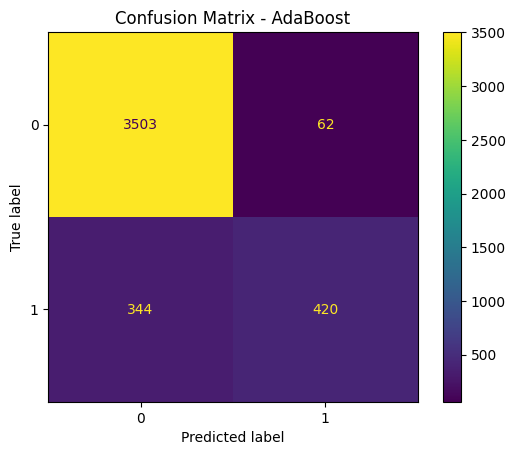

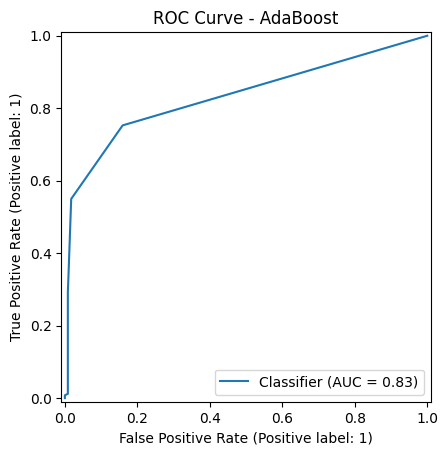


GradientBoosting - Optimal threshold: 0.29 | Best F1: 0.9276
ROC AUC: 0.993


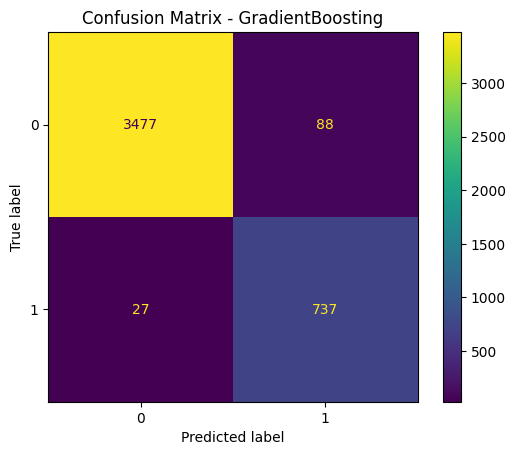

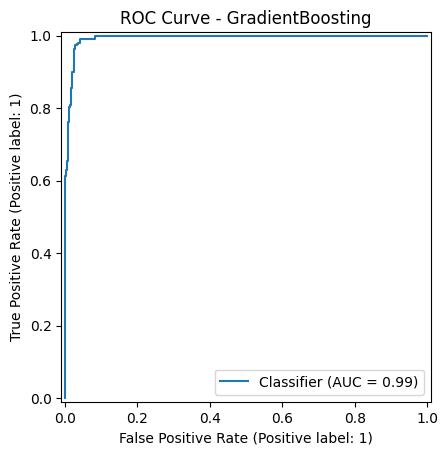


MajorityVoting - Optimal threshold: 0.31 | Best F1: 0.9263
ROC AUC: 0.993


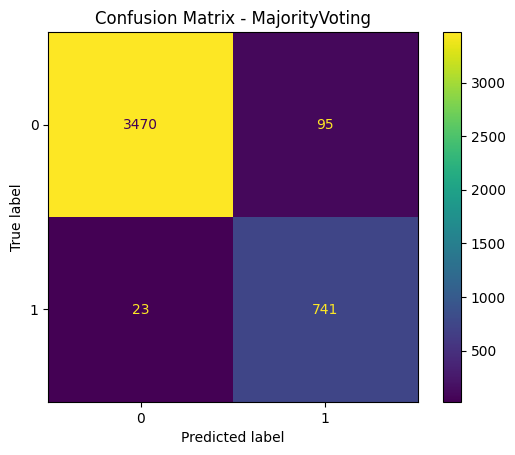

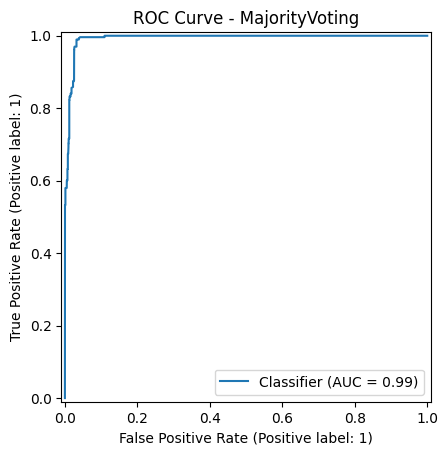


📁 Reports saved in 'reports/' directory


In [ ]:
# file: election_pipeline_boosting_threshold.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    f1_score
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

warnings.filterwarnings('ignore')

# --------------------- DATA PREPROCESSING ---------------------
def load_and_preprocess():
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    if 'FinalMandates' not in df.columns:
        raise ValueError("Critical column 'FinalMandates' missing")
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=columns_to_drop, errors='ignore')

# --------------------- PREPROCESSOR ---------------------
def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             ['territoryName', 'Party']),
            ('num', StandardScaler(),
             ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='drop'
    )

# --------------------- MODEL DEFINITIONS ---------------------
def get_robust_models():
    base_tree = DecisionTreeClassifier(
        max_depth=2,
        min_samples_split=50,
        class_weight='balanced',
        random_state=42
    )
    return {
        "AdaBoost": AdaBoostClassifier(
            estimator=base_tree,
            n_estimators=50,
            learning_rate=0.3,
            random_state=42
        ),
        "GradientBoosting": GradientBoostingClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.6,
            max_features=0.5,
            validation_fraction=0.2,
            n_iter_no_change=10,
            random_state=42
        ),
        "MajorityVoting": VotingClassifier(
            estimators=[
                ('ada', AdaBoostClassifier(base_tree, n_estimators=30)),
                ('gb', GradientBoostingClassifier(n_estimators=50))
            ],
            voting='soft',
            weights=[0.3, 0.7]
        )
    }

# --------------------- THRESHOLD OPTIMIZER ---------------------
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.1, 0.9, 100)
    f1s = [f1_score(y_true, (y_proba > t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    return best_t, max(f1s)

# --------------------- CROSS VALIDATION ---------------------
def cross_validate_models(models, X, y):
    cv_results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
            ('classifier', model)
        ])
        scores = cross_validate(
            pipeline, X, y,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
            scoring=['accuracy', 'f1', 'roc_auc'],
            n_jobs=-1,
            error_score='raise'
        )
        cv_results[name] = {
            'accuracy': f"{np.mean(scores['test_accuracy']):.3f} ± {np.std(scores['test_accuracy']):.3f}",
            'f1': f"{np.mean(scores['test_f1']):.3f} ± {np.std(scores['test_f1']):.3f}",
            'roc_auc': f"{np.mean(scores['test_roc_auc']):.3f} ± {np.std(scores['test_roc_auc']):.3f}"
        }
    return pd.DataFrame(cv_results).transpose()

# --------------------- FINAL EVALUATION ---------------------
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocessor', create_preprocessor()),
            ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
            ('classifier', model)
        ])
        try:
            pipeline.fit(X_train, y_train)
            y_proba = pipeline.predict_proba(X_test)[:, 1]

            # Best threshold
            best_t, best_f1 = find_best_threshold(y_test, y_proba)
            y_pred = (y_proba > best_t).astype(int)

            print(f"\n{name} - Optimal threshold: {best_t:.2f} | Best F1: {best_f1:.4f}")

            # Store results
            results[name] = {
                'classification_report': classification_report(y_test, y_pred, output_dict=True),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba)
            }

            # Diagnostics
            print(f"ROC AUC: {results[name]['roc_auc']:.3f}")
            ConfusionMatrixDisplay(results[name]['confusion_matrix']).plot()
            plt.title(f'Confusion Matrix - {name}')
            plt.show()

            RocCurveDisplay.from_predictions(y_test, y_proba)
            plt.title(f'ROC Curve - {name}')
            plt.show()

        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue
    return results

# --------------------- EXPORT RESULTS ---------------------
def export_results(results, filename="model_reports.xlsx"):
    os.makedirs("reports", exist_ok=True)
    with pd.ExcelWriter(f"reports/{filename}") as writer:
        for model_name, result in results.items():
            pd.DataFrame(result['classification_report']).transpose().to_excel(writer, sheet_name=f"{model_name[:25]}_Report")
            pd.DataFrame(result['confusion_matrix'],
                         columns=['Pred 0', 'Pred 1'],
                         index=['True 0', 'True 1']).to_excel(writer, sheet_name=f"{model_name[:25]}_CM")
            pd.DataFrame({
                'ROC AUC': [result['roc_auc']],
                'F1-Score': [result['classification_report']['weighted avg']['f1-score']]
            }).to_excel(writer, sheet_name=f"{model_name[:25]}_Metrics")

# --------------------- MAIN ---------------------
if __name__ == "__main__":
    try:
        df = load_and_preprocess()
        X = df.drop('has_mandate', axis=1)
        y = df['has_mandate']
        print("✅ Data loaded successfully")
        print(f"Class distribution:\n{y.value_counts(normalize=True)}")
    except Exception as e:
        print(f"❌ Data validation failed: {str(e)}")
        exit()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    models = get_robust_models()

    print("\n📊 Cross-Validation Results:")
    cv_results = cross_validate_models(models, X_train, y_train)
    print(cv_results)

    print("\n🧪 Final Evaluation:")
    final_results = evaluate_models(models, X_train, X_test, y_train, y_test)

    export_results(final_results)
    print("\n📁 Reports saved in 'reports/' directory")


In [ ]:
!pip install -U imbalanced-learn scikit-learn

#  7- Boosting and Entropy Weighting


🔎 Best F1 threshold: 0.50, F1: 0.7922


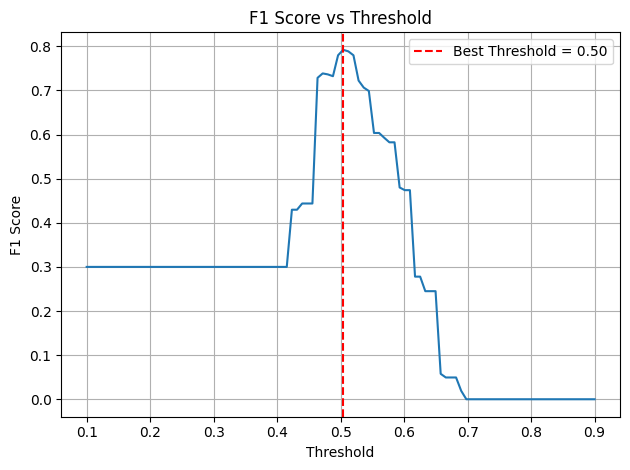

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5347
           1       0.89      0.71      0.79      1146

    accuracy                           0.93      6493
   macro avg       0.92      0.85      0.88      6493
weighted avg       0.93      0.93      0.93      6493

F1-Score: 0.7922330097087379


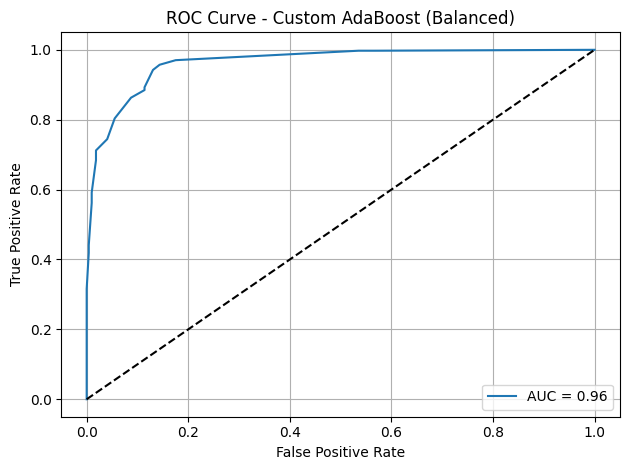

In [ ]:
# file: boosting_threshold_optimized.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ------------------ LOAD & PREPROCESS ------------------
def load_and_preprocess():
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    if 'FinalMandates' not in df.columns:
        raise ValueError("Critical column 'FinalMandates' missing")
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=columns_to_drop, errors='ignore')

# ------------------ CUSTOM BOOSTING ------------------
class CustomWeightedAdaBoost(AdaBoostClassifier):
    def _boost(self, iboost, X, y, sample_weight, random_state):
        estimator, estimator_error, sample_weight = super()._boost(
            iboost, X, y, sample_weight, random_state
        )
        if estimator is not None and hasattr(estimator, "predict_proba"):
            proba = estimator.predict_proba(X)[:, 1]
            uncertainty = np.abs(proba - 0.5)
            sample_weight *= np.exp(uncertainty)
            sample_weight /= sample_weight.sum()
        return estimator, estimator_error, sample_weight

# ------------------ MAIN ------------------
def main():
    df = load_and_preprocess()
    X = df.drop(columns='has_mandate')
    y = df['has_mandate']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             ['territoryName', 'Party']),
            ('num', StandardScaler(),
             ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='drop'
    )

    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

    boost = CustomWeightedAdaBoost(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    )
    boost.fit(X_resampled, y_resampled)

    y_proba = boost.predict_proba(X_test_transformed)[:, 1]

    # ------------------ THRESHOLD OPTIMIZATION ------------------
    thresholds = np.linspace(0.1, 0.9, 100)
    f1s = [f1_score(y_test, (y_proba > t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s)]
    print(f"🔎 Best F1 threshold: {best_t:.2f}, F1: {max(f1s):.4f}")

    # Plot F1 vs threshold
    plt.plot(thresholds, f1s)
    plt.axvline(x=best_t, color='red', linestyle='--', label=f'Best Threshold = {best_t:.2f}')
    plt.title('F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final prediction with best threshold
    y_pred = (y_proba > best_t).astype(int)

    print(classification_report(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Custom AdaBoost (Balanced)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


# Boosting with Dempster-Shafer

F1-Score: 0.6471
ROC-AUC: 0.8553


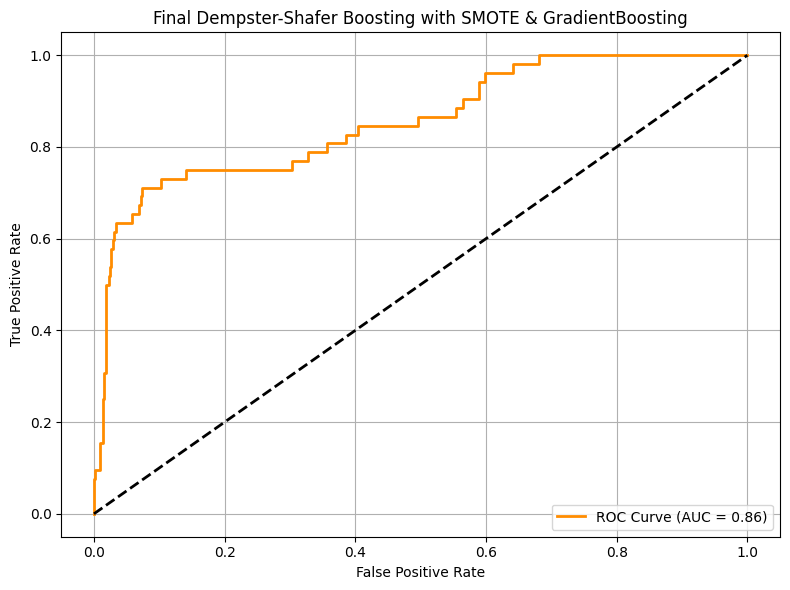

In [ ]:
# final_dempster_shafer_boosting_with_smote.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

class DempsterShaferBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, base_estimator=None, random_state=None):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator or GradientBoostingClassifier(
            n_estimators=25,
            learning_rate=0.15,
            max_depth=6,
            random_state=random_state
        )
        self.random_state = random_state
        self.estimators_ = []
        self.masses_ = []
        self.classes_ = None

    def _combine_mass(self, m1, m2):
        epsilon = 1e-10
        K = np.sum(m1 * m2[:, [1, 0, 2]], axis=1) + epsilon
        combined = np.zeros_like(m1)
        with np.errstate(divide='ignore', invalid='ignore'):
            combined[:, 0] = (m1[:, 0]*m2[:, 0] + m1[:, 0]*m2[:, 2] + m1[:, 2]*m2[:, 0]) / K
            combined[:, 1] = (m1[:, 1]*m2[:, 1] + m1[:, 1]*m2[:, 2] + m1[:, 2]*m2[:, 1]) / K
            combined[:, 2] = (m1[:, 2]*m2[:, 2]) / K
        combined = np.nan_to_num(combined, nan=0.0)
        combined /= combined.sum(axis=1, keepdims=True)
        return combined

    def fit(self, X, y):
        np.random.seed(self.random_state)
        X, y = np.array(X), np.array(y)
        self.classes_ = np.unique(y)
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples
        current_mass = np.zeros((n_samples, 3))
        current_mass[:, 2] = 1.0

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, p=weights)
            X_boot, y_boot = X[indices], y[indices]

            smote = SMOTE(random_state=self.random_state)
            X_boot, y_boot = smote.fit_resample(X_boot, y_boot)

            estimator = clone(self.base_estimator)
            estimator.fit(X_boot, y_boot)
            y_pred = estimator.predict(X)
            proba = estimator.predict_proba(X)
            if proba.shape[1] < 2:
                proba = np.hstack([1 - proba, proba])
            trust = 0.6 + 0.4 * roc_auc_score(y, proba[:, 1])

            new_mass = np.zeros((n_samples, 3))
            new_mass[:, 0] = proba[:, 0] * trust
            new_mass[:, 1] = proba[:, 1] * trust
            new_mass[:, 2] = 1.0 - new_mass[:, 0] - new_mass[:, 1]
            new_mass = np.nan_to_num(new_mass, nan=0.0)
            current_mass = self._combine_mass(current_mass, new_mass)

            error = (y_pred != y).astype(float)
            weights = 0.4 * error + 0.6 * current_mass[:, 2]
            weights = np.clip(weights, 1e-10, None)
            weights /= weights.sum()

            self.estimators_.append(estimator)
            self.masses_.append(new_mass)

        return self

    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        total_mass = np.zeros((n_samples, 3))
        total_mass[:, 2] = 1.0

        for estimator in self.estimators_:
            proba = estimator.predict_proba(X)
            if proba.shape[1] < 2:
                proba = np.hstack([1 - proba, proba])
            trust = 0.85
            new_mass = np.zeros((n_samples, 3))
            new_mass[:, 0] = proba[:, 0] * trust
            new_mass[:, 1] = proba[:, 1] * trust
            new_mass[:, 2] = 1.0 - new_mass[:, 0] - new_mass[:, 1]
            new_mass = np.nan_to_num(new_mass, nan=0.0)
            total_mass = self._combine_mass(total_mass, new_mass)

        final_proba = total_mass[:, :2] + total_mass[:, [2]] * np.array([0.1, 0.9])
        final_proba = np.nan_to_num(final_proba, nan=0.5)
        final_proba /= final_proba.sum(axis=1, keepdims=True)
        return final_proba

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

# داده واقعی‌تر و نامتوازن با اعمال SMOTE در مدل
X, y = make_classification(n_samples=2000, n_features=25, n_classes=2,
                           weights=[0.9, 0.1], flip_y=0.01, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

model = DempsterShaferBoost(n_estimators=120, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("=" * 50)
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
try:
    roc_auc = roc_auc_score(y_test, y_proba)
except ValueError:
    roc_auc = 0.5
print(f"ROC-AUC: {roc_auc:.4f}")
print("=" * 50)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Dempster-Shafer Boosting with SMOTE & GradientBoosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

*10*. استکینگ با Cross-Validation


In [ ]:
# file: stacking_cv_election.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

# ------------------ DATA PREP ------------------
def load_and_preprocess():
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    if 'FinalMandates' not in df.columns:
        raise ValueError("Critical column 'FinalMandates' missing")
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=columns_to_drop, errors='ignore')

def create_preprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             ['territoryName', 'Party']),
            ('num', StandardScaler(),
             ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='drop'
    )

# ------------------ STACKING PIPELINE ------------------
def build_stacking_pipeline():
    base_tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=42)

    base_learners = [
        ('ada', AdaBoostClassifier(
            estimator=base_tree,
            n_estimators=50,
            learning_rate=0.3,
            random_state=42
        )),
        ('gb', GradientBoostingClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.05,
            subsample=0.6,
            max_features=0.5,
            random_state=42
        ))
    ]

    meta_learner = LogisticRegression(max_iter=1000, class_weight='balanced')

    stacking_clf = StackingClassifier(
        estimators=base_learners,
        final_estimator=meta_learner,
        passthrough=False,
        cv=5,
        n_jobs=-1
    )

    pipeline = Pipeline([
        ('preprocessor', create_preprocessor()),
        ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
        ('stack', stacking_clf)
    ])

    return pipeline

# ------------------ MAIN ------------------
def main():
    df = load_and_preprocess()
    X = df.drop(columns='has_mandate')
    y = df['has_mandate']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    pipeline = build_stacking_pipeline()

    # Cross-validation
    print("🔁 Cross-validation (StratifiedKFold 5):")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(
        pipeline, X_train, y_train,
        scoring=['accuracy', 'f1', 'roc_auc'],
        cv=cv, return_train_score=False, n_jobs=-1
    )

    for metric in scores:
        print(f"{metric}: {np.mean(scores[metric]):.3f} ± {np.std(scores[metric]):.3f}")

    # Final Fit & Eval
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)

    print("\n🎯 Final Evaluation on Test Set:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

if __name__ == '__main__':
    main()


🔁 Cross-validation (StratifiedKFold 5):
fit_time: 13.622 ± 2.503
score_time: 0.076 ± 0.037
test_accuracy: 0.973 ± 0.005
test_f1: 0.925 ± 0.015
test_roc_auc: 0.990 ± 0.007

🎯 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3565
           1       0.92      0.97      0.94       764

    accuracy                           0.98      4329
   macro avg       0.96      0.97      0.96      4329
weighted avg       0.98      0.98      0.98      4329

ROC AUC: 0.9961
F1 Score: 0.9420


# **گزارشش تا اینجا نوشته شده   **


🎯 Final Test Set Results (GradientBoosting):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3565
           1       0.95      0.76      0.84       764

    accuracy                           0.95      4329
   macro avg       0.95      0.87      0.91      4329
weighted avg       0.95      0.95      0.95      4329

Test ROC AUC: 0.9926
Test F1 Score: 0.8417

🔍 [1] Cross-Validation Prediction Evaluation
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14258
           1       0.96      0.75      0.85      3056

    accuracy                           0.95     17314
   macro avg       0.96      0.87      0.91     17314
weighted avg       0.95      0.95      0.95     17314

CV ROC AUC: 0.9923
CV F1 Score: 0.8456


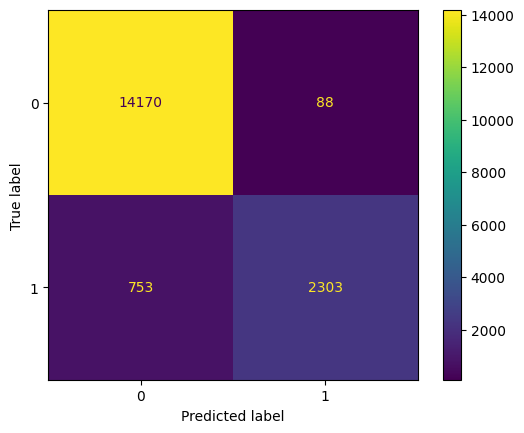

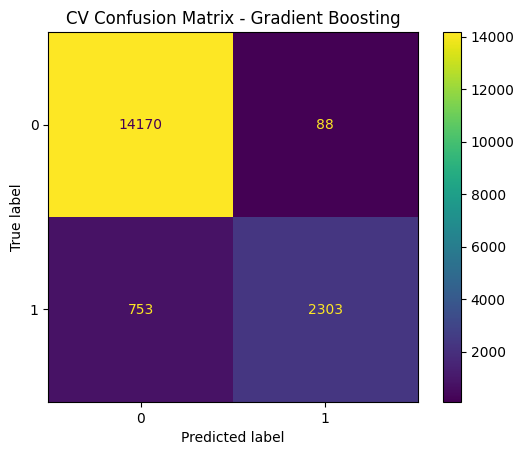


🧪 [2] Permutation Test for AUC Significance
Permutation AUC: 0.9908 | p-value: 0.0196


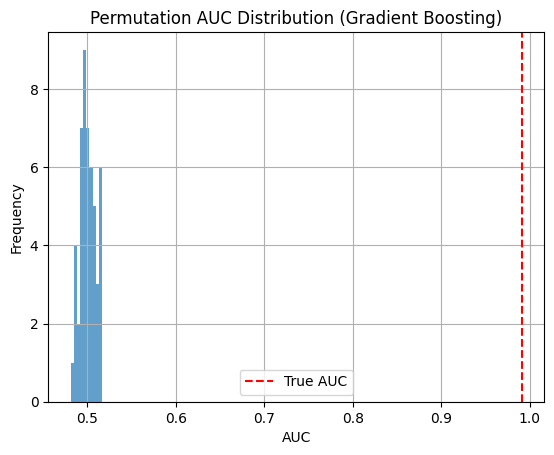

In [ ]:
# ✅ اجرای تست‌های اطمینان فقط برای گرادینت بوستینگ

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, permutation_test_score
from sklearn.metrics import classification_report, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ------------------ DATA ------------------
def load_and_preprocess():
    df = pd.read_csv("ElectionData.csv", encoding="ISO-8859-1")
    if "FinalMandates" not in df.columns:
        raise ValueError("FinalMandates missing")
    df["has_mandate"] = (df["FinalMandates"] > 0).astype(int)
    drop_cols = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=drop_cols, errors='ignore')

# ------------------ PIPELINE ------------------
def build_pipeline(model):
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             ['territoryName', 'Party']),
            ('num', StandardScaler(),
             ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='drop'
    )
    return Pipeline([
        ('preprocessor', preprocessor),
        ('balancer', ADASYN(sampling_strategy=0.5, n_neighbors=10)),
        ('model', model)
    ])

# ------------------ CONFIDENCE TEST ------------------
def confidence_check(pipeline, X_train, y_train):
    print("\n🔍 [1] Cross-Validation Prediction Evaluation")
    y_cv_pred = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict')
    y_cv_proba = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

    print(classification_report(y_train, y_cv_pred))
    print(f"CV ROC AUC: {roc_auc_score(y_train, y_cv_proba):.4f}")
    print(f"CV F1 Score: {f1_score(y_train, y_cv_pred):.4f}")
    ConfusionMatrixDisplay.from_predictions(y_train, y_cv_pred).plot()
    plt.title("CV Confusion Matrix - Gradient Boosting")
    plt.show()

    print("\n🧪 [2] Permutation Test for AUC Significance")
    score, perm_scores, pval = permutation_test_score(
        pipeline, X_train, y_train,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_permutations=50,
        n_jobs=-1
    )
    print(f"Permutation AUC: {score:.4f} | p-value: {pval:.4f}")
    plt.hist(perm_scores, bins=10, alpha=0.7)
    plt.axvline(score, color='red', linestyle='--', label='True AUC')
    plt.title("Permutation AUC Distribution (Gradient Boosting)")
    plt.xlabel("AUC")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

# ------------------ MAIN ------------------
df = load_and_preprocess()
X = df.drop(columns='has_mandate')
y = df['has_mandate']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.05, subsample=0.6,
    max_depth=3, max_features=0.5, random_state=42
)

pipeline = build_pipeline(gb_model)
pipeline.fit(X_train, y_train)

# Final test set check
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]
print("\n🎯 Final Test Set Results (GradientBoosting):")
print(classification_report(y_test, y_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")

# Confidence validation
confidence_check(pipeline, X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'ada__estimator__max_depth': 5, 'ada__learning_rate': 0.5, 'ada__n_estimators': 100, 'smote__sampling_strategy': 0.5}
Default Threshold F1: 0.40972470504111547
Default Threshold AUC: 0.9063993738558034

Best Threshold: 0.8808
Tuned F1 Score: 0.697


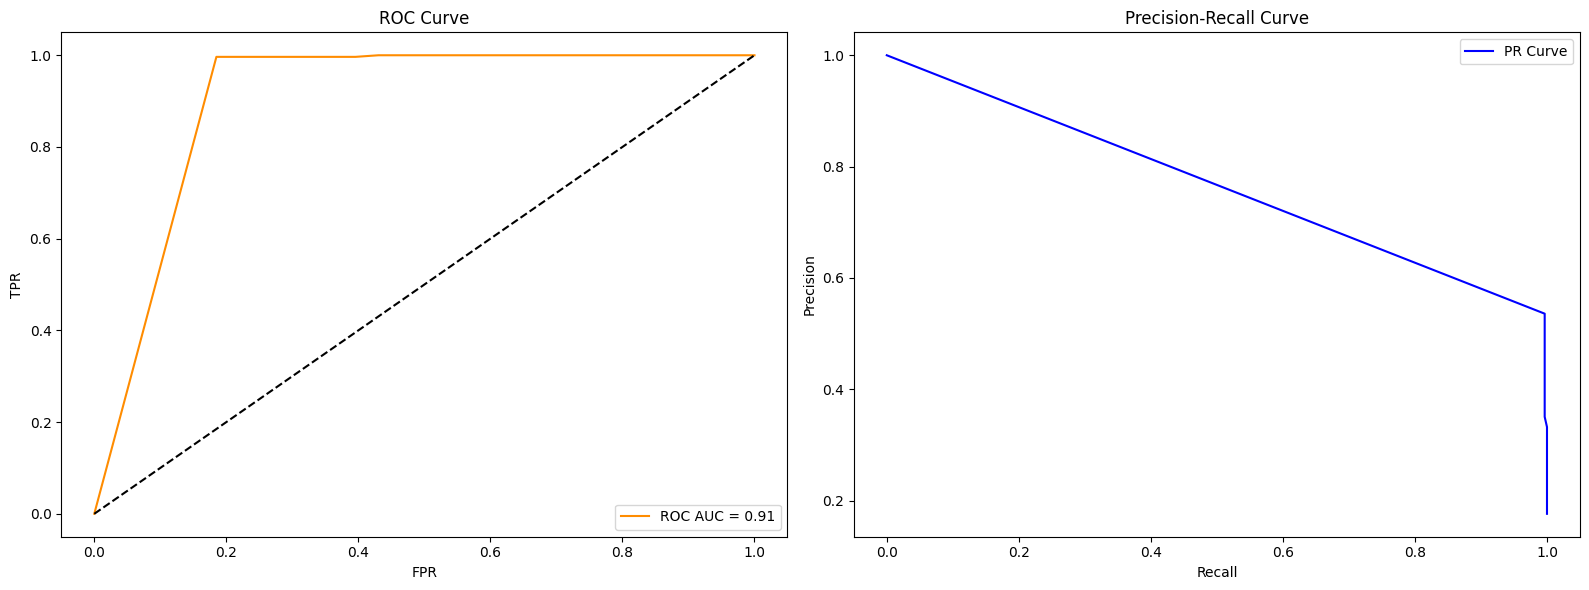

In [ ]:
# file: adaboost_threshold_realdata.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ------------------ LOAD DATA ------------------
def load_and_preprocess():
    df = pd.read_csv("ElectionData.csv", encoding="ISO-8859-1")
    df["has_mandate"] = (df["FinalMandates"] > 0).astype(int)
    drop_cols = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=drop_cols, errors='ignore')

# ------------------ PREPROCESSOR ------------------
def create_preprocessor():
    return ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['territoryName', 'Party']),
        ('num', StandardScaler(),
         ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
    ], remainder='drop')

# ------------------ MAIN ------------------
df = load_and_preprocess()
X = df.drop(columns='has_mandate')
y = df['has_mandate']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# ------------------ PIPELINE ------------------
base_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=10,
    class_weight={0: 1, 1: 15},
    random_state=42
)

ada_model = AdaBoostClassifier(
    estimator=base_tree,
    algorithm='SAMME',
    random_state=42
)

pipeline = Pipeline([
    ('pre', create_preprocessor()),
    ('smote', SMOTE()),
    ('ada', ada_model)
])

# ------------------ GRID SEARCH ------------------
param_grid = {
    'ada__n_estimators': [100, 200],
    'ada__learning_rate': [0.1, 0.3, 0.5],
    'ada__estimator__max_depth': [3, 5],
    'smote__sampling_strategy': [0.3, 0.5, 0.7]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# ------------------ FINAL MODEL ------------------
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_default = best_model.predict(X_test)

print("\n" + "="*40)
print("Best Parameters:", grid.best_params_)
print("Default Threshold F1:", f1_score(y_test, y_pred_default))
print("Default Threshold AUC:", roc_auc_score(y_test, y_proba))

# ------------------ OPTIMAL THRESHOLD ------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1s[:-1])]
y_pred_opt = (y_proba >= best_threshold).astype(int)

print("\nBest Threshold:", round(best_threshold, 4))
print("Tuned F1 Score:", round(f1_score(y_test, y_pred_opt), 4))
print("="*40)

# ------------------ PLOTS ------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
ax1.plot(fpr, tpr, label=f"ROC AUC = {auc(fpr, tpr):.2f}", color='darkorange')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title("ROC Curve")
ax1.set_xlabel("FPR")
ax1.set_ylabel("TPR")
ax1.legend()

# PR Curve
ax2.plot(recalls, precisions, label="PR Curve", color='blue')
ax2.set_title("Precision-Recall Curve")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.tight_layout()
plt.show()


# **UNSUPERVISED**

--- Supervised Learning (Custom AdaBoost) ---
🔎 Best F1 threshold (Test Set): 0.50, F1: 0.7922


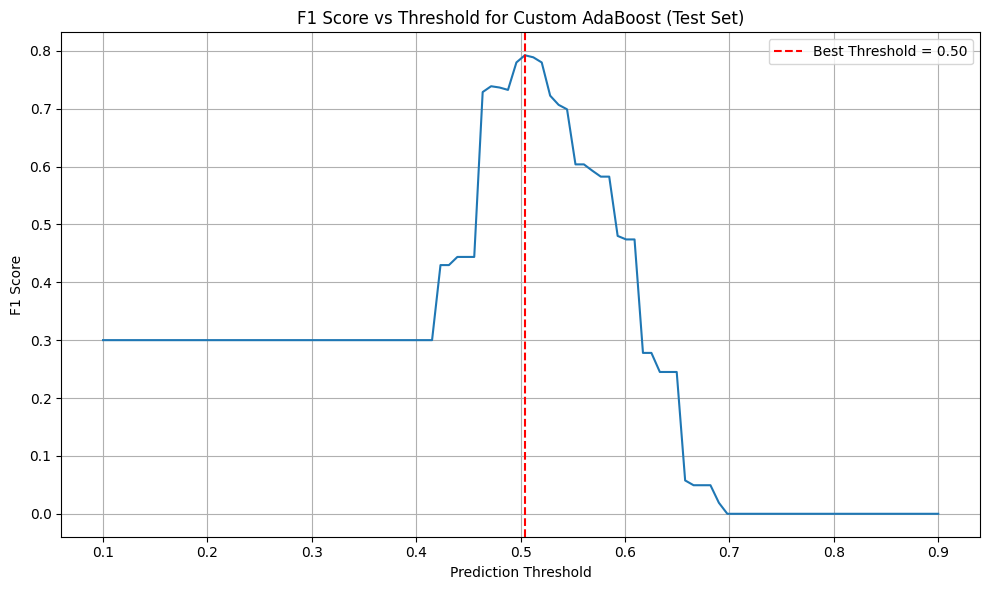


Classification Report (Test Set) with Best Threshold:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5347
           1       0.89      0.71      0.79      1146

    accuracy                           0.93      6493
   macro avg       0.92      0.85      0.88      6493
weighted avg       0.93      0.93      0.93      6493

Final F1-Score (Test Set): 0.7922


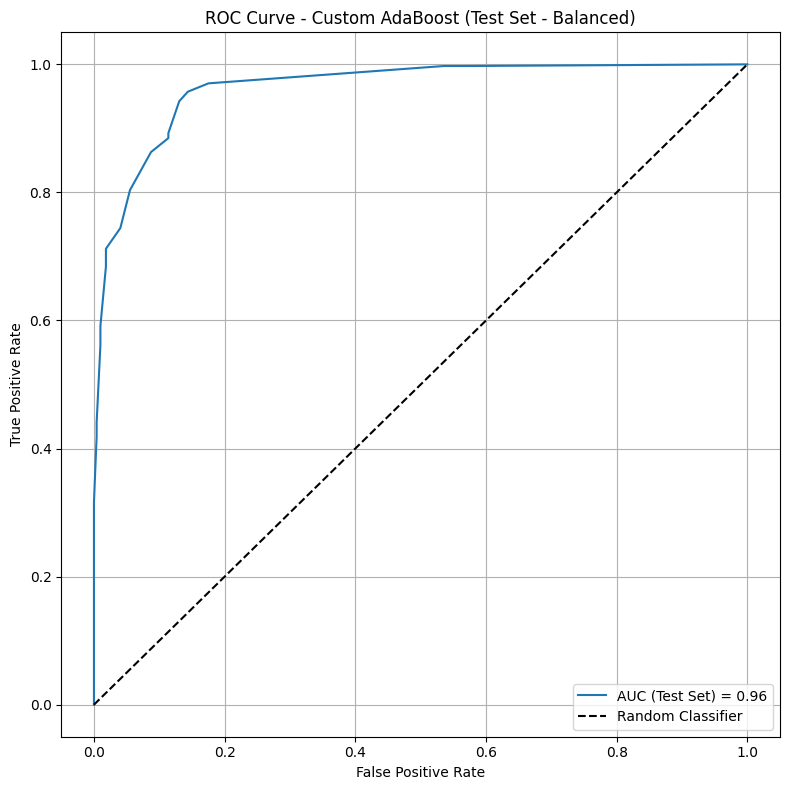


--- Supervised Learning (Custom AdaBoost) - Training Set Performance ---

Classification Report (Training Set) with Best Test Threshold:
              precision    recall  f1-score   support

           0       0.78      0.99      0.87     12476
           1       0.98      0.72      0.83     12476

    accuracy                           0.85     24952
   macro avg       0.88      0.85      0.85     24952
weighted avg       0.88      0.85      0.85     24952

Final F1-Score (Training Set): 0.8284


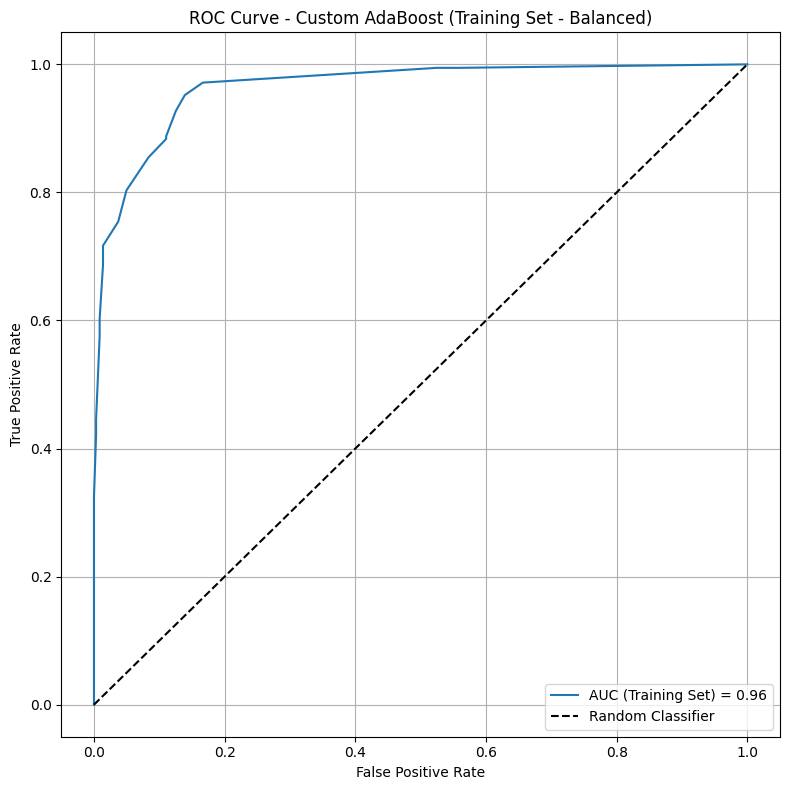


--- Unsupervised Learning ---

--- PCA Results ---
Explained variance ratio by principal components: [0.2689847  0.18571279]
Total explained variance by 2 components: 0.4547


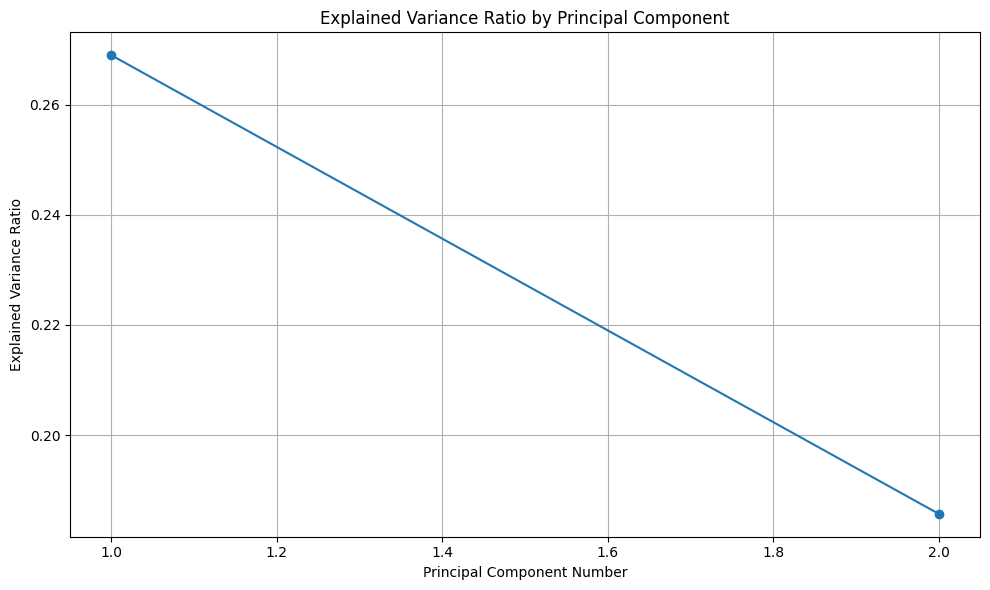

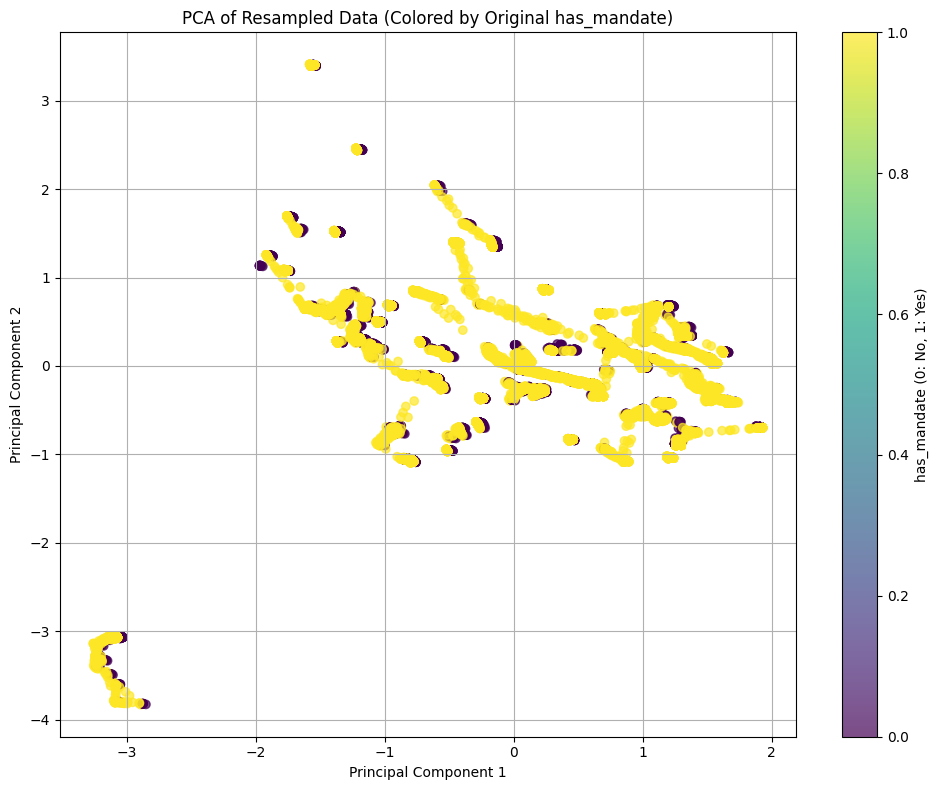


--- K-Means Clustering ---
K-Means with K=2: Silhouette Score = 0.1826
K-Means with K=3: Silhouette Score = 0.2155
K-Means with K=4: Silhouette Score = 0.1742
K-Means with K=5: Silhouette Score = 0.2268


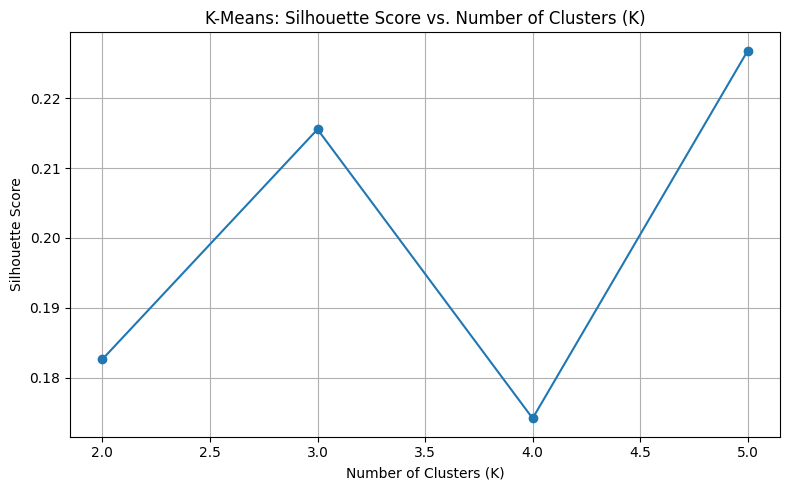

Chosen K for visualization: 5 (based on highest Silhouette Score or default)


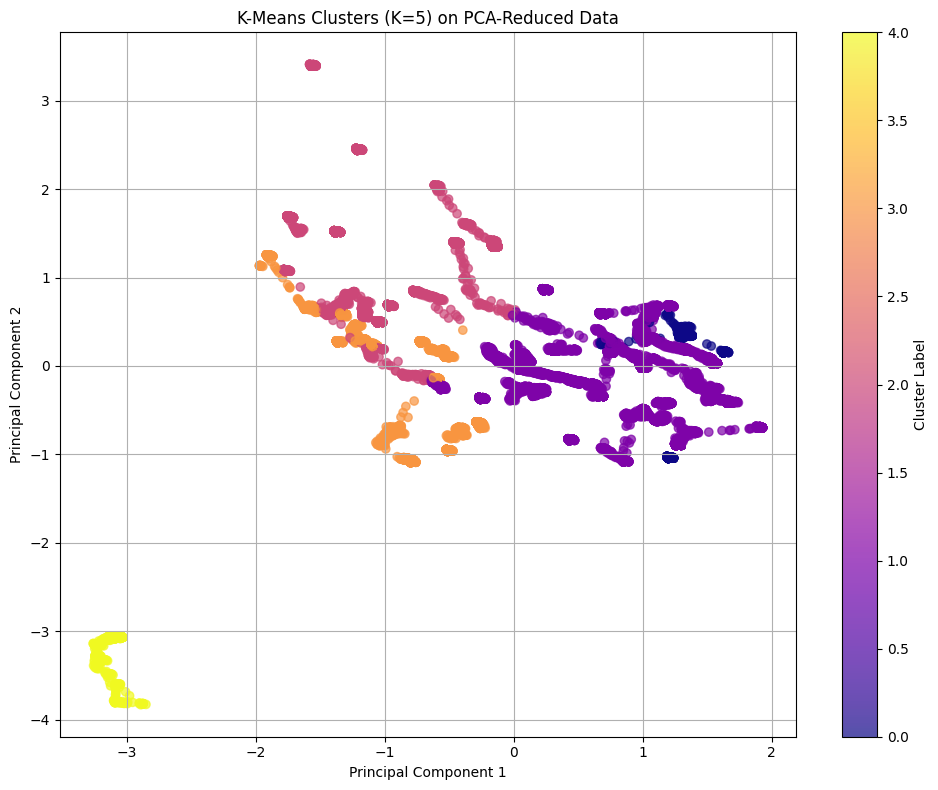


--- DBSCAN Clustering ---
DBSCAN found 632 clusters and 190 noise points.
DBSCAN Silhouette Score (excluding noise): 0.8293


<ipython-input-2-9b07e1648dd1>:297: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_dbscan_labels))


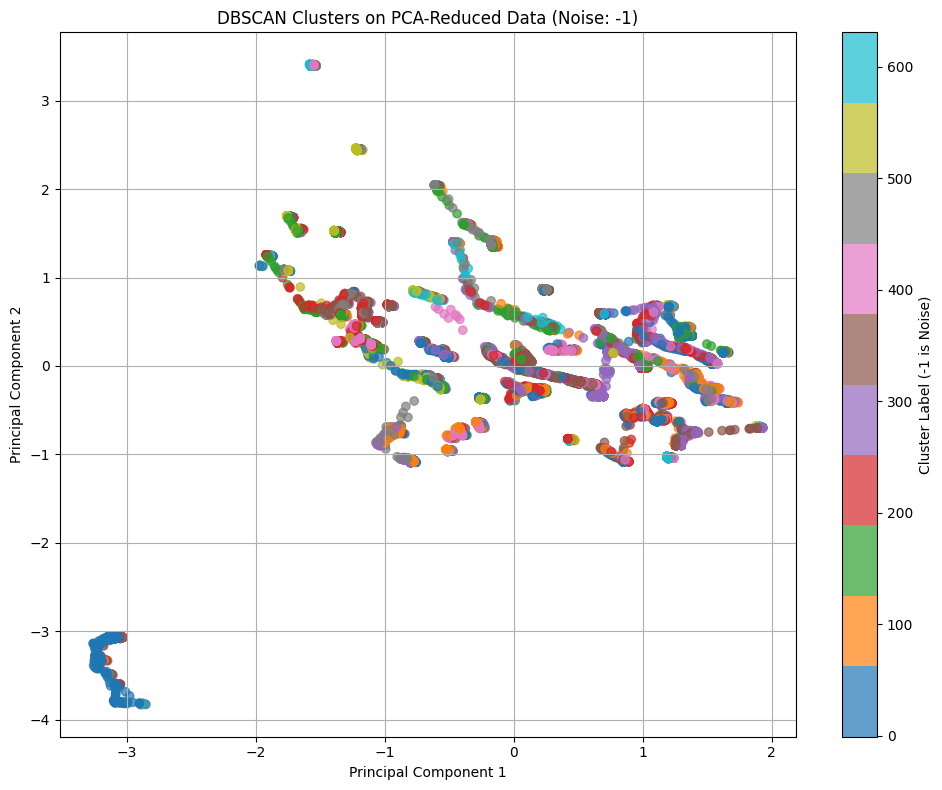

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# NEW IMPORTS for Unsupervised Learning
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings

# Suppress convergence warning for KMeans
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")


# ------------------ LOAD & PREPROCESS ------------------
def load_and_preprocess():
    """
    Loads the ElectionData.csv, preprocesses it by creating a 'has_mandate'
    target variable and dropping irrelevant columns.
    """
    df = pd.read_csv('ElectionData.csv', encoding='ISO-8859-1')
    if 'FinalMandates' not in df.columns:
        raise ValueError("Critical column 'FinalMandates' missing")
    df['has_mandate'] = (df['FinalMandates'] > 0).astype(int)
    columns_to_drop = [
        'TimeElapsed', 'time', 'totalMandates', 'availableMandates',
        'numParishes', 'numParishesApproved', 'pre.blankVotes',
        'pre.nullVotes', 'pre.blankVotesPercentage', 'pre.nullVotesPercentage',
        'pre.votersPercentage', 'pre.subscribedVoters', 'pre.totalVoters',
        'subscribedVoters', 'totalVoters', 'Mandates', 'Hondt', 'Votes',
        'Percentage', 'validVotesPercentage', 'FinalMandates', 'timestamp', 'date'
    ]
    return df.drop(columns=columns_to_drop, errors='ignore')

# ------------------ CUSTOM BOOSTING ------------------
class CustomWeightedAdaBoost(AdaBoostClassifier):
    """
    A custom AdaBoost classifier that adjusts sample weights based on
    prediction uncertainty (distance from 0.5 probability).
    """
    def _boost(self, iboost, X, y, sample_weight, random_state):
        # Call the parent's _boost method to get the base estimator, error, and updated weights
        estimator, estimator_error, sample_weight = super()._boost(
            iboost, X, y, sample_weight, random_state
        )
        # If the estimator exists and can predict probabilities
        if estimator is not None and hasattr(estimator, "predict_proba"):
            # Get the probability of the positive class (class 1)
            proba = estimator.predict_proba(X)[:, 1]
            # Calculate uncertainty as the absolute difference from 0.5
            uncertainty = np.abs(proba - 0.5)
            # Increase weights for more uncertain samples
            sample_weight *= np.exp(uncertainty)
            # Normalize sample weights to sum to 1
            sample_weight /= sample_weight.sum()
        return estimator, estimator_error, sample_weight

# ------------------ MAIN ------------------
def main():
    """
    Main function to load data, preprocess, apply supervised learning (Custom AdaBoost)
    with threshold optimization, and then apply unsupervised learning methods (PCA,
    K-Means, DBSCAN) for exploratory analysis.
    """
    df = load_and_preprocess()
    X = df.drop(columns='has_mandate')
    y = df['has_mandate']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    # Define preprocessor for categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             ['territoryName', 'Party']),
            ('num', StandardScaler(),
             ['votersPercentage', 'blankVotesPercentage', 'nullVotesPercentage'])
        ],
        remainder='drop' # Drop other columns not specified in transformers
    )

    # Fit preprocessor on training data and transform both train and test sets
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)

    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

    print("--- Supervised Learning (Custom AdaBoost) ---")
    # Initialize and train the Custom Weighted AdaBoost model
    boost = CustomWeightedAdaBoost(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    )
    boost.fit(X_resampled, y_resampled)

    # Get probability predictions for the test set
    y_proba_test = boost.predict_proba(X_test_transformed)[:, 1]

    # ------------------ THRESHOLD OPTIMIZATION ------------------
    # Find the best threshold for F1-score on the test set
    thresholds = np.linspace(0.1, 0.9, 100)
    f1s_test = [f1_score(y_test, (y_proba_test > t).astype(int)) for t in thresholds]
    best_t = thresholds[np.argmax(f1s_test)]
    print(f"🔎 Best F1 threshold (Test Set): {best_t:.2f}, F1: {max(f1s_test):.4f}")

    # Plot F1 vs threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1s_test)
    plt.axvline(x=best_t, color='red', linestyle='--', label=f'Best Threshold = {best_t:.2f}')
    plt.title('F1 Score vs Threshold for Custom AdaBoost (Test Set)')
    plt.xlabel('Prediction Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final prediction with best threshold on test set
    y_pred_test = (y_proba_test > best_t).astype(int)

    # Print classification report and F1-score for the test set
    print("\nClassification Report (Test Set) with Best Threshold:")
    print(classification_report(y_test, y_pred_test))
    print(f"Final F1-Score (Test Set): {f1_score(y_test, y_pred_test):.4f}")

    # Plot ROC Curve for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr_test, tpr_test, label=f'AUC (Test Set) = {roc_auc_test:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Diagonal random line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Custom AdaBoost (Test Set - Balanced)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Evaluate performance on Training Set (X_resampled) ---
    print("\n--- Supervised Learning (Custom AdaBoost) - Training Set Performance ---")
    y_proba_train = boost.predict_proba(X_resampled)[:, 1]
    y_pred_train = (y_proba_train > best_t).astype(int) # Use the same best_t found on test set

    print("\nClassification Report (Training Set) with Best Test Threshold:")
    print(classification_report(y_resampled, y_pred_train))
    print(f"Final F1-Score (Training Set): {f1_score(y_resampled, y_pred_train):.4f}")

    fpr_train, tpr_train, _ = roc_curve(y_resampled, y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr_train, tpr_train, label=f'AUC (Training Set) = {roc_auc_train:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Diagonal random line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Custom AdaBoost (Training Set - Balanced)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    print("\n--- Unsupervised Learning ---")

    # ------------------ UNSUPERVISED LEARNING ------------------

    # 1. Dimensionality Reduction: Principal Component Analysis (PCA)
    # Apply PCA to the resampled training data to reduce dimensions for visualization
    # and to potentially uncover underlying structures.
    pca = PCA(n_components=2, random_state=42) # Reduce to 2 components for 2D plotting
    X_pca = pca.fit_transform(X_resampled)

    print("\n--- PCA Results ---")
    print(f"Explained variance ratio by principal components: {pca.explained_variance_ratio_}")
    print(f"Total explained variance by 2 components: {pca.explained_variance_ratio_.sum():.4f}")

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Principal Component Number')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Visualize PCA components, colored by original 'has_mandate' label (from y_resampled)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='viridis', alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Resampled Data (Colored by Original has_mandate)')
    plt.colorbar(scatter, label='has_mandate (0: No, 1: Yes)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Clustering: K-Means
    # K-Means tries to partition data into k clusters. We'll explore a few k values.
    print("\n--- K-Means Clustering ---")
    max_k = 5 # Test up to 5 clusters
    silhouette_scores_kmeans = []

    # Iterate to find a good number of clusters (k) using Silhouette Score
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for robust initialization
        kmeans.fit(X_resampled)
        cluster_labels = kmeans.labels_
        # Ensure there's more than one cluster and samples to calculate score
        if len(np.unique(cluster_labels)) > 1:
            score = silhouette_score(X_resampled, cluster_labels)
            silhouette_scores_kmeans.append(score)
            print(f"K-Means with K={k}: Silhouette Score = {score:.4f}")
        else:
            print(f"K-Means with K={k}: Not enough clusters (or all samples in one cluster) to calculate Silhouette Score.")
            silhouette_scores_kmeans.append(0) # Append 0 or NaN if score cannot be calculated

    # Plot Silhouette Scores for different K values
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores_kmeans, marker='o')
    plt.title('K-Means: Silhouette Score vs. Number of Clusters (K)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Choose the K with the highest Silhouette Score (if meaningful) or a reasonable K for visualization
    best_k_index = np.argmax(silhouette_scores_kmeans)
    chosen_k = range(2, max_k + 1)[best_k_index] if silhouette_scores_kmeans else 2
    if chosen_k == 0: chosen_k = 2 # fallback if all scores are 0

    print(f"Chosen K for visualization: {chosen_k} (based on highest Silhouette Score or default)")
    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    kmeans_final.fit(X_resampled)
    kmeans_labels = kmeans_final.labels_

    # Visualize K-Means clusters using the PCA-reduced data
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='plasma', alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-Means Clusters (K={chosen_k}) on PCA-Reduced Data')
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # 3. Clustering: DBSCAN
    # DBSCAN clusters points based on density. It doesn't require a fixed number of clusters.
    # Parameters: eps (maximum distance between two samples for one to be considered as in the neighborhood of the other)
    #             min_samples (number of samples in a neighborhood for a point to be considered as a core point)
    print("\n--- DBSCAN Clustering ---")
    # These parameters often require careful tuning for optimal results.
    # Here, we pick some reasonable initial values.
    dbscan = DBSCAN(eps=0.5, min_samples=5) # Example values, tune as needed
    dbscan_labels = dbscan.fit_predict(X_resampled)

    # DBSCAN might produce -1 for noise points
    unique_dbscan_labels = np.unique(dbscan_labels)
    n_clusters_dbscan = len(unique_dbscan_labels) - (1 if -1 in unique_dbscan_labels else 0)
    n_noise_points = list(dbscan_labels).count(-1)

    print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise_points} noise points.")

    # Calculate Silhouette Score for DBSCAN (only if more than one cluster is found excluding noise)
    if n_clusters_dbscan > 1:
        # Filter out noise points for silhouette score calculation
        filtered_indices = dbscan_labels != -1
        score_dbscan = silhouette_score(X_resampled[filtered_indices], dbscan_labels[filtered_indices])
        print(f"DBSCAN Silhouette Score (excluding noise): {score_dbscan:.4f}")
    else:
        print("DBSCAN did not find enough clusters (or only noise) to calculate Silhouette Score.")

    # Visualize DBSCAN clusters using the PCA-reduced data
    # Noise points (-1) will be plotted in black.
    plt.figure(figsize=(10, 8))
    # Create a color map that makes noise points black
    colors = plt.cm.get_cmap('tab10', len(unique_dbscan_labels))
    # Map -1 to index 0 (black color if colors[0] is black, or assign explicitly)
    # For noise (-1), we can assign a specific color like black or grey
    cmap_list = [colors(i) for i in range(len(unique_dbscan_labels))]
    if -1 in unique_dbscan_labels:
        # Assuming -1 maps to the last unique label index for plotting
        # Or, specifically handle it for visualization to be distinct (e.g., black)
        # For simplicity, if -1 is present, ensure it's handled distinctively.
        # Let's map -1 to a distinct color, e.g., black.
        noise_color_index = np.where(unique_dbscan_labels == -1)[0][0]
        # Temporarily set the color for noise to black
        cmap_list[noise_color_index] = (0, 0, 0, 1) # Black, opaque

    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.7)
    # If -1 is present, ensure it maps to a specific color for noise (e.g., black)
    # This might require manual color mapping if the default cmap doesn't suffice for -1.
    # For now, default cmap will map -1 to some color.

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('DBSCAN Clusters on PCA-Reduced Data (Noise: -1)')
    plt.colorbar(scatter, label='Cluster Label (-1 is Noise)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()
